<a href="https://colab.research.google.com/github/RaisaAnika/loan_nbfc_hacathon/blob/main/NBFC_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NBFC Loan Default
*by Garey Salinas*

----

<a id=top></a>
## Contents

- [Overview of Dataset](#overview)
- [Exploratory Data Analysis](#eda)
- [Data Preparation](#processing)
- [Model Building](#modelbuilding)
- [Cross Validation Scores](#cross_validation_scores)
- [XGBoost Classifier](#xgbc)
- [Bagging Classifier](#bagging)
- [Decision Tree Classifier](#dtree)
- [Stacking Classifier](#stacking)
- [Test Set Prediction](#testset)

----


### Background

A non-banking financial institution (NBFI) or non-bank financial company (NBFC) is a Financial Institution that does not have a full banking license or is not supervised by a national or international banking regulatory agency. NBFC facilitates bank-related financial services, such as investment, risk pooling, contractual savings, and market brokering.
The following is the story of a challenge faced by DHDL Ltd. (Name Changed), an NBFC in India. In recent times, the company is struggling to mark profits due to an increase in Loan Defaults. The company aims to determine the relative importance of each parameter with regards to their contribution as to whether a loan is going to default or not. Provided is a sample that contains the data of 90,000 + clients who have taken a loan from the company in the past with the information on whether the loan defaulted. 

----

### Objective

The objective of this exercise is to understand which parameters play an important role in determining whether a client will default on the loan payment.

----

### Data Dictionary

|Labels|Description|
|:-----|:----------|
|ID|unique ID assigned to each applicant|
|loan_amnt|loan amount ($) applied each applicant|
|loan_term|Loan duration in years|
|interest_rate|Applicable interest rate on Loan in %|
|loan_grade|Loan Grade Assigned by the bank|
|loan_subgrade|Loan SubGrade Assigned by the bank|
|job_experience|Number of years job experience| 
|home_ownership|Status of House Ownership|
|annual_income|Annual income of the applicant|
|income_verification_status|Status of Income verification by the bank|
|loan_purpose|Purpose of loan|
|state_code|State code of the applicant's residence|
|debt_to_income|Ratio to total debt to income (total debt might include other loan aswell)|
|delinq_2yrs|number of 30+ days delinquency in past 2 years|
|public_records|number of legal cases against the applicant|
|revolving_balance|total credit revolving balance|
|total_acc|total number of credit lines available in members credit line|
|interest_receive|total interest received by the bank on the loan|
|application_type|Whether the applicant has applied the loan by creating individuall or joint account|
|last_week_pay|How many months have the applicant paid the loan EMI already|
|total_current_balance|total current balance of all the accounts of applicant|
|total_revolving_limit|total revolving credit limit|
|default|status of loan amount, 1 = Defaulter, 0 = Non Defaulters|



----

<a id=overview></a>
## <span style="color:blue">Overview of Dataset</span>
<div style="text-align:right"><a href=#top>top</a></div>

### Import Libraries

In [38]:
import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np   
import pandas as pd    
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    make_scorer
)
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    StackingClassifier
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)

# to suppress scientific notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
sns.set()

### Load dataset

In [39]:
data = pd.read_csv('Train_set.csv')
df = data.copy()

In [40]:
df.shape

(60973, 23)

In [41]:
pd.concat([df.head(5), df.sample(5), df.tail(5)])

ID  loan_amnt  ... total_revolving_limit  default
0      72199369       9000  ...             84100.000    0.000
1      14257956      18000  ...             13500.000    0.000
2      66216451      16000  ...             19300.000    0.000
3      46974169      25000  ...             55400.000    0.000
4      46725961      17000  ...             81300.000    0.000
3818   43376297      10000  ...             35100.000    0.000
58957   1274988       5300  ...                   nan    1.000
20914  38671214      28000  ...             50500.000    0.000
18936  70325422       2400  ...             11200.000    0.000
34468  62494356      15000  ...              6800.000    0.000
60968  53987821      15200  ...             17500.000    0.000
60969  73413312      24000  ...             82800.000    0.000
60970  36184756      20000  ...             35400.000    0.000
60971   8411177      15000  ...             41900.000    0.000
60972  31065883       8675  ...                   nan      nan

[15 rows x 23 columns]

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60973 entries, 0 to 60972
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          60973 non-null  int64  
 1   loan_amnt                   60973 non-null  int64  
 2   loan_term                   60973 non-null  object 
 3   interest_rate               60973 non-null  float64
 4   loan_grade                  60973 non-null  object 
 5   loan_subgrade               60973 non-null  object 
 6   job_experience              57888 non-null  object 
 7   home_ownership              60973 non-null  object 
 8   annual_income               60973 non-null  float64
 9   income_verification_status  60973 non-null  object 
 10  loan_purpose                60973 non-null  object 
 11  state_code                  60973 non-null  object 
 12  debt_to_income              60973 non-null  float64
 13  delinq_2yrs                 609

In [43]:
display(df.describe(include='all').T)
display(df.describe(include='float').T)
df.describe(include='object').T

count unique  ...          75%          max
ID                         60973.000    NaN  ... 58459137.000 73519746.000
loan_amnt                  60973.000    NaN  ...    20000.000    35000.000
loan_term                      60973      2  ...          NaN          NaN
interest_rate              60973.000    NaN  ...       16.200       28.990
loan_grade                     60973      7  ...          NaN          NaN
loan_subgrade                  60973     35  ...          NaN          NaN
job_experience                 57888      3  ...          NaN          NaN
home_ownership                 60973      5  ...          NaN          NaN
annual_income              60973.000    NaN  ...    90000.000  9500000.000
income_verification_status     60973      3  ...          NaN          NaN
loan_purpose                   60973      4  ...          NaN          NaN
state_code                     60973     50  ...          NaN          NaN
debt_to_income             60973.000    NaN  ...       23.940      672.520
delinq_2yrs                60973.000    NaN  ...        0.000       21.000
public_records             60973.000    NaN  ...        0.000       49.000
revolving_balance          60973.000    NaN  ...    20796.000  2560703.000
total_acc                  60973.000    NaN  ...       32.000      119.000
interest_receive           60973.000    NaN  ...     2217.260    23172.310
application_type               60973      3  ...          NaN          NaN
last_week_pay              59735.000    NaN  ...       83.000      274.000
total_current_balance      56172.000    NaN  ...   208406.500  8000078.000
total_revolving_limit      56172.000    NaN  ...    39800.000  9999999.000
default                    60972.000    NaN  ...        0.000        1.000

[23 rows x 11 columns]

count       mean  ...        75%         max
interest_rate         60973.000     13.219  ...     16.200      28.990
annual_income         60973.000  75350.712  ...  90000.000 9500000.000
debt_to_income        60973.000     18.142  ...     23.940     672.520
delinq_2yrs           60973.000      0.317  ...      0.000      21.000
public_records        60973.000      0.197  ...      0.000      49.000
total_acc             60973.000     25.245  ...     32.000     119.000
interest_receive      60973.000   1742.807  ...   2217.260   23172.310
last_week_pay         59735.000     58.088  ...     83.000     274.000
total_current_balance 56172.000 139957.925  ... 208406.500 8000078.000
total_revolving_limit 56172.000  32250.960  ...  39800.000 9999999.000
default               60972.000      0.239  ...      0.000       1.000

[11 rows x 8 columns]

count unique                 top   freq
loan_term                   60973      2             3 years  42760
loan_grade                  60973      7                   B  17634
loan_subgrade               60973     35                  B4   3821
job_experience              57888      3            <5 Years  26616
home_ownership              60973      5            MORTGAGE  30511
income_verification_status  60973      3     Source Verified  22654
loan_purpose                60973      4  debt_consolidation  36293
state_code                  60973     50                  CA   8966
application_type            60973      3          INDIVIDUAL  60935

In [44]:
try:
    df.drop(['ID'], axis=1, inplace=True)
except:
    print("ID column already dropped")
df.columns

Index(['loan_amnt', 'loan_term', 'interest_rate', 'loan_grade',
       'loan_subgrade', 'job_experience', 'home_ownership', 'annual_income',
       'income_verification_status', 'loan_purpose', 'state_code',
       'debt_to_income', 'delinq_2yrs', 'public_records', 'revolving_balance',
       'total_acc', 'interest_receive', 'application_type', 'last_week_pay',
       'total_current_balance', 'total_revolving_limit', 'default'],
      dtype='object')

In [45]:
df.isnull().sum().sort_values(ascending=False)

total_current_balance         4801
total_revolving_limit         4801
job_experience                3085
last_week_pay                 1238
default                          1
income_verification_status       0
loan_term                        0
interest_rate                    0
loan_grade                       0
loan_subgrade                    0
home_ownership                   0
annual_income                    0
state_code                       0
loan_purpose                     0
debt_to_income                   0
delinq_2yrs                      0
public_records                   0
revolving_balance                0
total_acc                        0
interest_receive                 0
application_type                 0
loan_amnt                        0
dtype: int64

In [46]:
df.isnull().sum()

loan_amnt                        0
loan_term                        0
interest_rate                    0
loan_grade                       0
loan_subgrade                    0
job_experience                3085
home_ownership                   0
annual_income                    0
income_verification_status       0
loan_purpose                     0
state_code                       0
debt_to_income                   0
delinq_2yrs                      0
public_records                   0
revolving_balance                0
total_acc                        0
interest_receive                 0
application_type                 0
last_week_pay                 1238
total_current_balance         4801
total_revolving_limit         4801
default                          1
dtype: int64

In [47]:
df.duplicated().sum()

0

In [48]:
cat_cols = df.select_dtypes(include='object').columns
df[cat_cols] = df[cat_cols].astype('category')
df.select_dtypes(include='category').columns

Index(['loan_term', 'loan_grade', 'loan_subgrade', 'job_experience',
       'home_ownership', 'income_verification_status', 'loan_purpose',
       'state_code', 'application_type'],
      dtype='object')

In [49]:
for i in df.select_dtypes(include=['category']).columns:
    print('Unique values in', i, 'are :')
    print(df[i].value_counts(dropna=False))
    print('*'*50)

Unique values in loan_term are :
3 years    42760
5 years    18213
Name: loan_term, dtype: int64
**************************************************
Unique values in loan_grade are :
B    17634
C    16808
A    10234
D     9606
E     4802
F     1524
G      365
Name: loan_grade, dtype: int64
**************************************************
Unique values in loan_subgrade are :
B4    3821
B3    3821
C1    3557
C2    3515
B2    3417
C3    3417
C4    3404
B5    3347
B1    3228
A5    3093
C5    2915
D1    2449
A4    2401
D2    2076
D3    1836
D4    1779
A3    1611
A1    1582
A2    1547
D5    1466
E1    1274
E2    1114
E3     944
E4     818
E5     652
F1     501
F2     353
F3     306
F4     217
F5     147
G1     122
G2      91
G3      73
G5      41
G4      38
Name: loan_subgrade, dtype: int64
**************************************************
Unique values in job_experience are :
<5 Years      26616
10+ years     19794
6-10 years    11478
NaN            3085
Name: job_experience, dtype: int64

<a id=eda></a>
## <span style="color:blue">Exploratory Data Analysis</span>
<div style="text-align:right"><a href=#top>top</a></div>

### Univariate Analysis

In [50]:
def histogram_boxplot(feature, figsize=(15, 7), bins=None):
    """ 
    Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (15,10))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    
    sns.boxplot(feature, ax=ax_box2, showmeans=True, color='yellow') # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(feature, kde=True, ax=ax_hist2, bins=bins) if bins else sns.distplot(feature, kde=True, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='blue', linestyle='-');# Add median to the histogram

In [51]:
def perc_on_bar(feature):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''
    #Creating a countplot for the feature
    sns.set(rc={'figure.figsize':(15,7)})
    ax=sns.countplot(x=feature, data=data, palette='mako')
    
    total = len(feature) # length of the column
    for p in ax.patches:
        # percentage of each class of the category
        percentage = 100 * p.get_height()/total
        percentage_label = f"{percentage:.1f}%"
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot
        ax.annotate(percentage_label, (x, y), size = 12) # annotate the percantage
        
    plt.show() # show the plot

In [52]:
### Function to plot distributions and Boxplots of customers
def target_plot(x, target='default'):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''
    fig,axs = plt.subplots(2, 2, figsize=(12,10))
    axs[0, 0].set_title('Distribution of an default')
    sns.distplot(data[(data[target] == 1)][x], ax=axs[0,0], color='teal')
    axs[0, 1].set_title('Distribution of an non-default')
    sns.distplot(data[(data[target] == 0)][x], ax=axs[0,1], color='orange')
    
    axs[1,0].set_title('Boxplot w.r.t default')
    sns.boxplot(data[target],data[x], ax=axs[1,0],palette='gist_rainbow')
    axs[1,1].set_title('Boxplot w.r.t non-default - Without outliers')
    sns.boxplot(data[target],data[x],ax=axs[1,1],showfliers=False,palette='gist_rainbow')
    plt.tight_layout()
    plt.show()

In [53]:
df.select_dtypes(include='integer').columns

Index(['loan_amnt', 'revolving_balance'], dtype='object')

### loan_amnt

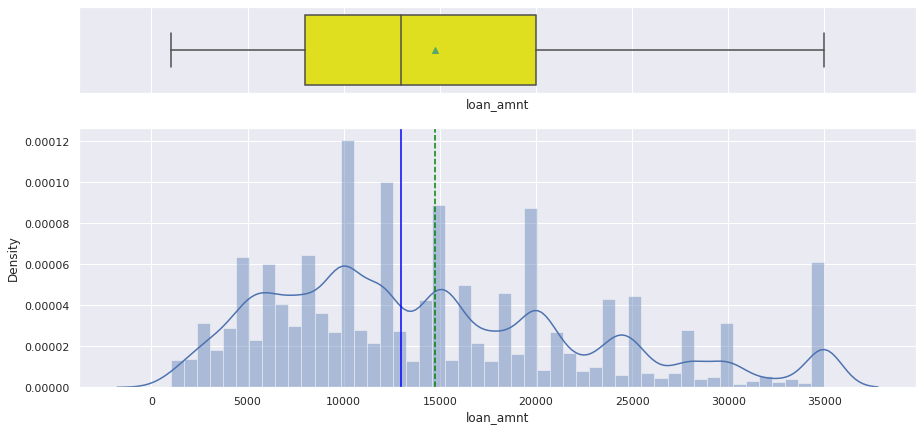

In [54]:
histogram_boxplot(df.loan_amnt)

### revolving_balance

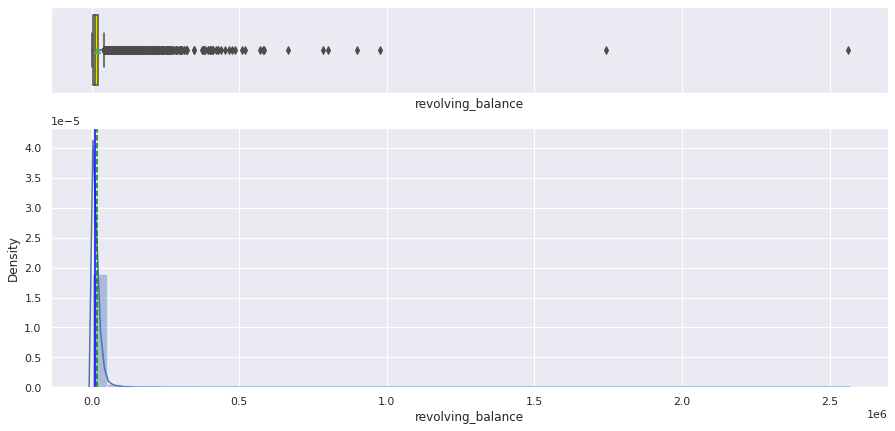

In [55]:
histogram_boxplot(df.revolving_balance)

### default

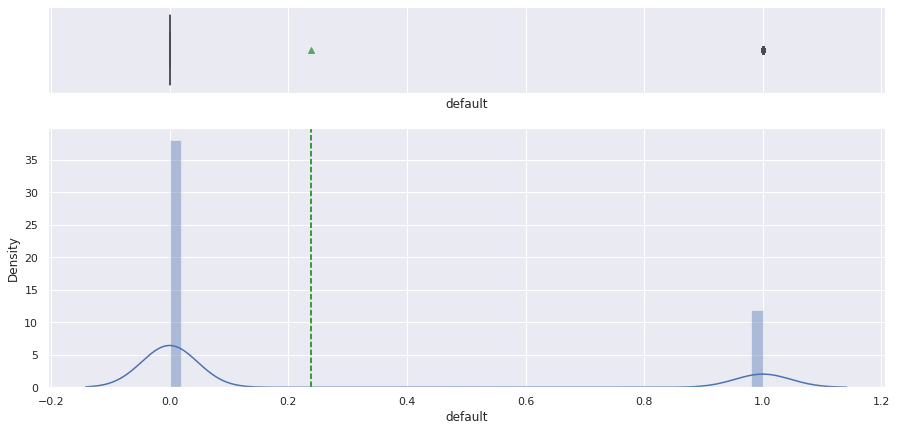

In [56]:
histogram_boxplot(df.default)

In [57]:
df.select_dtypes(include='float').columns

Index(['interest_rate', 'annual_income', 'debt_to_income', 'delinq_2yrs',
       'public_records', 'total_acc', 'interest_receive', 'last_week_pay',
       'total_current_balance', 'total_revolving_limit', 'default'],
      dtype='object')

### interest_rate

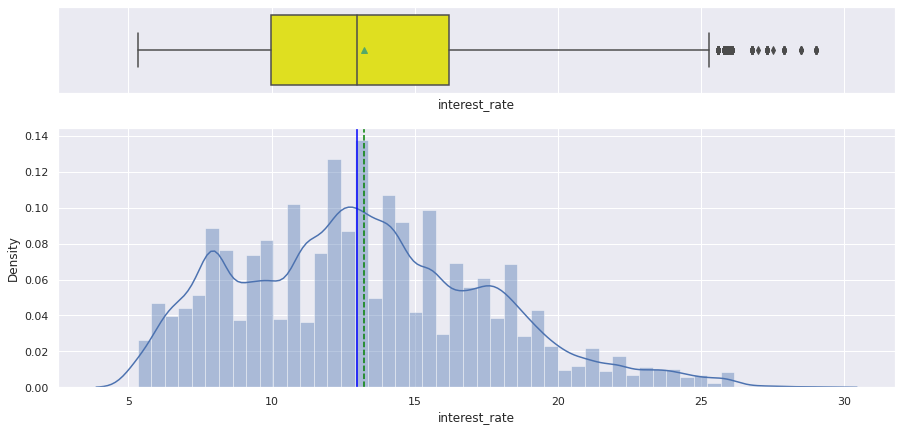

In [58]:
histogram_boxplot(df.interest_rate)

### annual_income

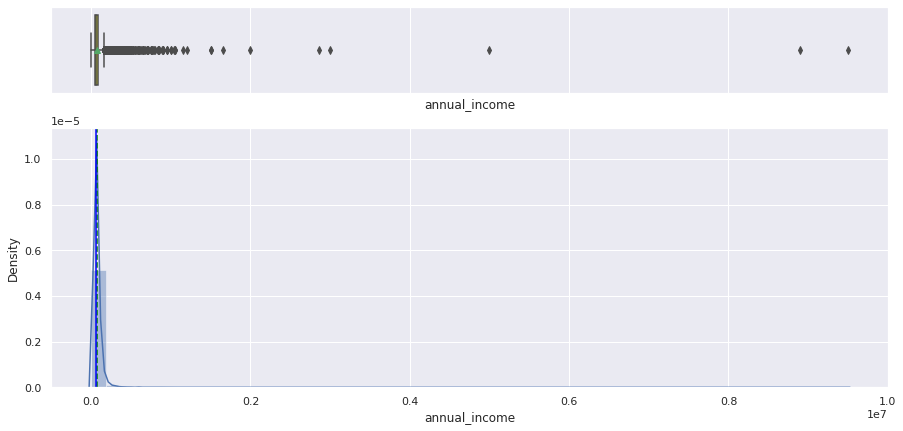

In [59]:
histogram_boxplot(df.annual_income)

### debt_to_income

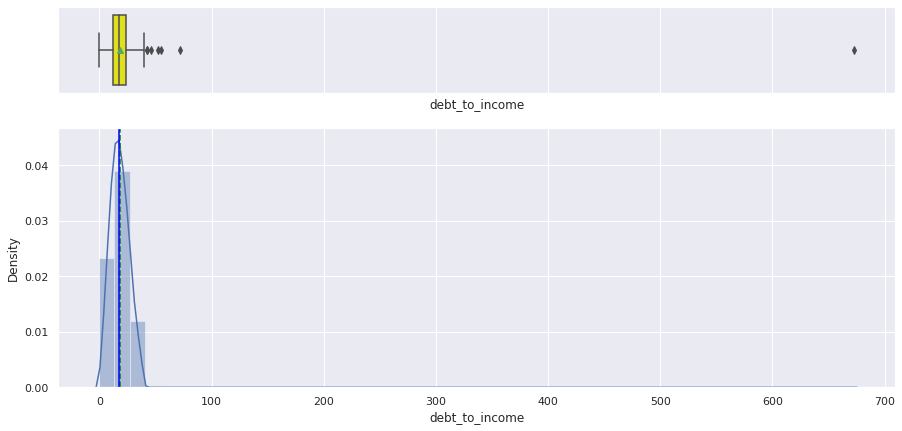

In [60]:
histogram_boxplot(df.debt_to_income)

### delinq_2yrs

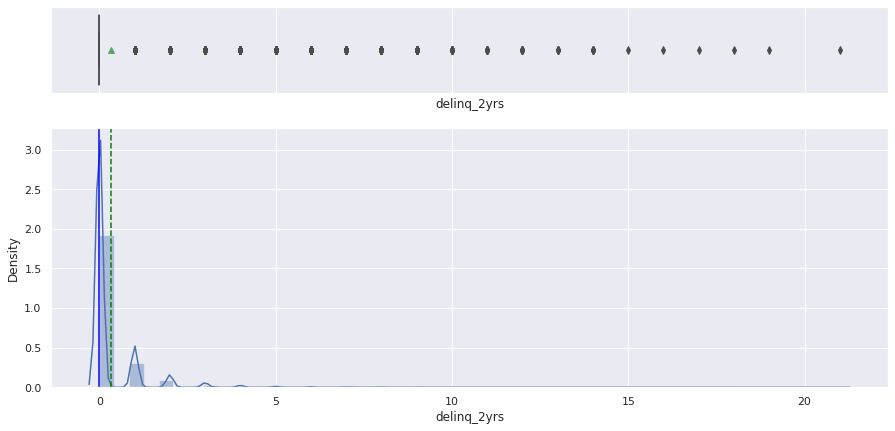

In [61]:
histogram_boxplot(df.delinq_2yrs)

### public_records

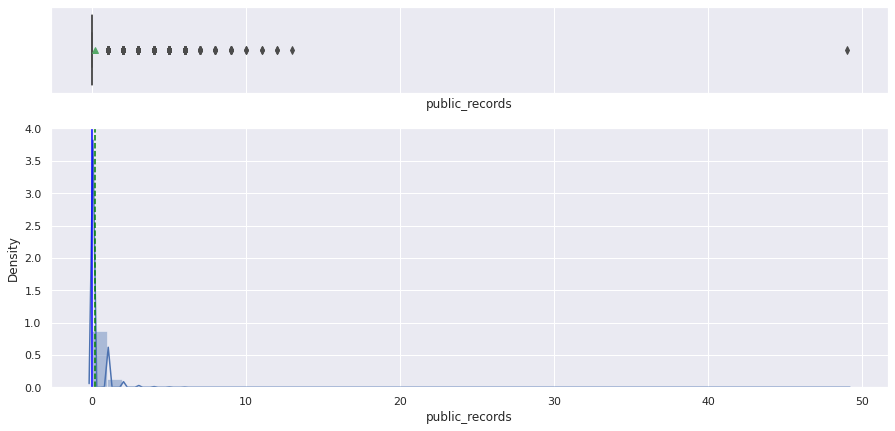

In [62]:
histogram_boxplot(df.public_records)

### total_acc

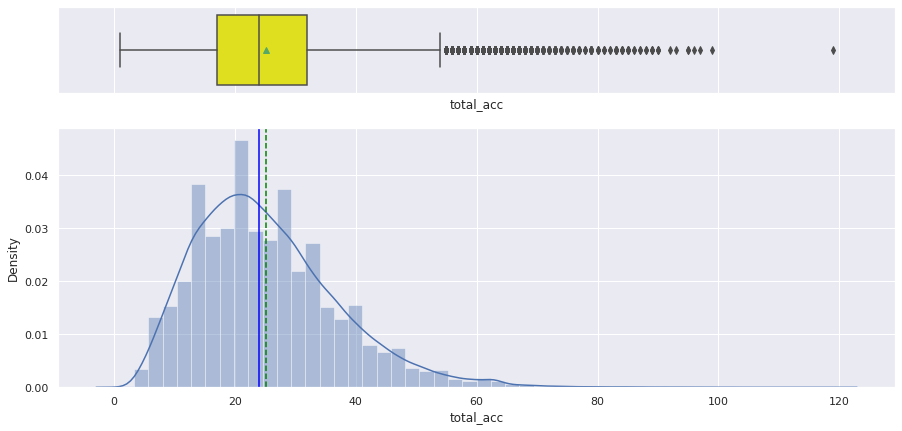

In [63]:
histogram_boxplot(df.total_acc)

### interest_receive

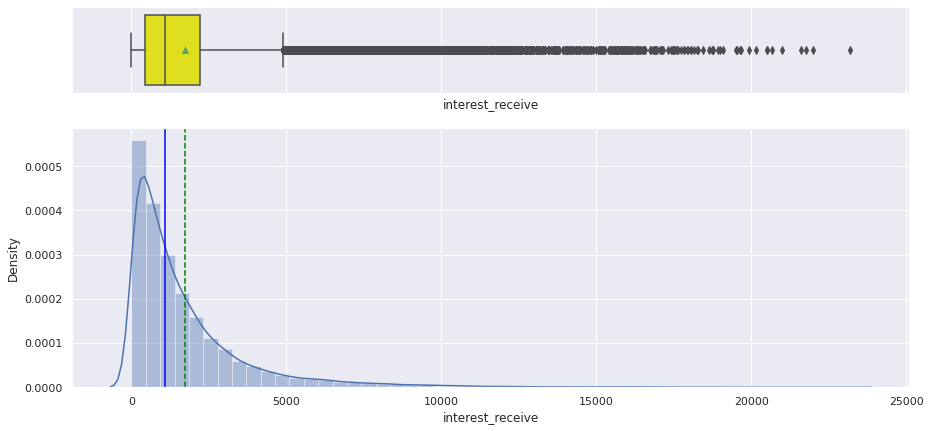

In [64]:
histogram_boxplot(df.interest_receive)

### last_week_pay

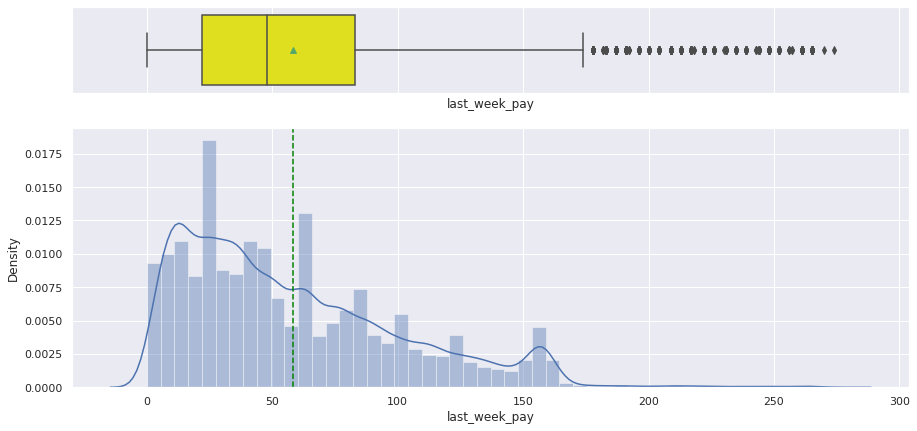

In [65]:
histogram_boxplot(df.last_week_pay)

### total_current_balance

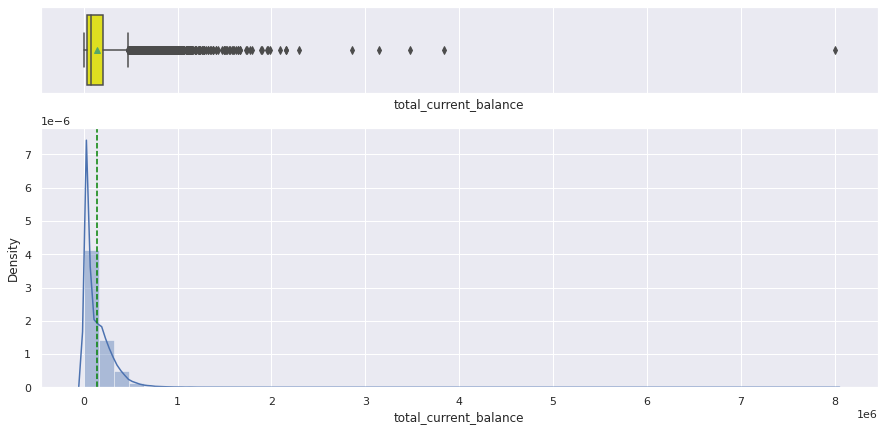

In [66]:
histogram_boxplot(df.total_current_balance)

### total_revolving_limit

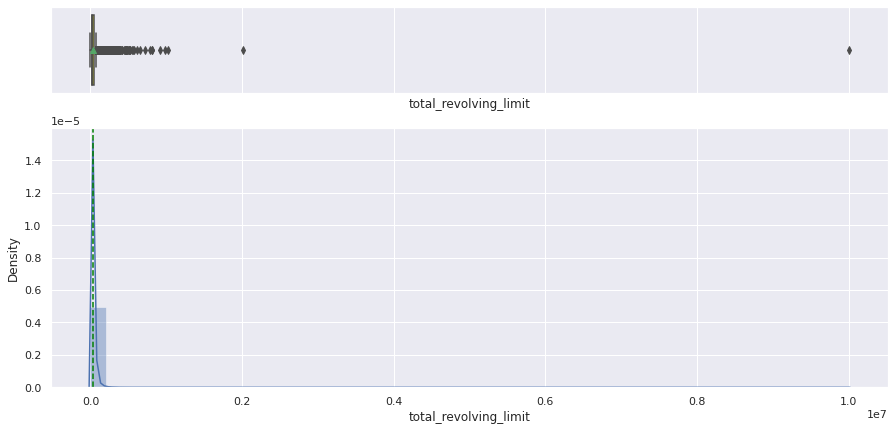

In [67]:
histogram_boxplot(df.total_revolving_limit)

### default

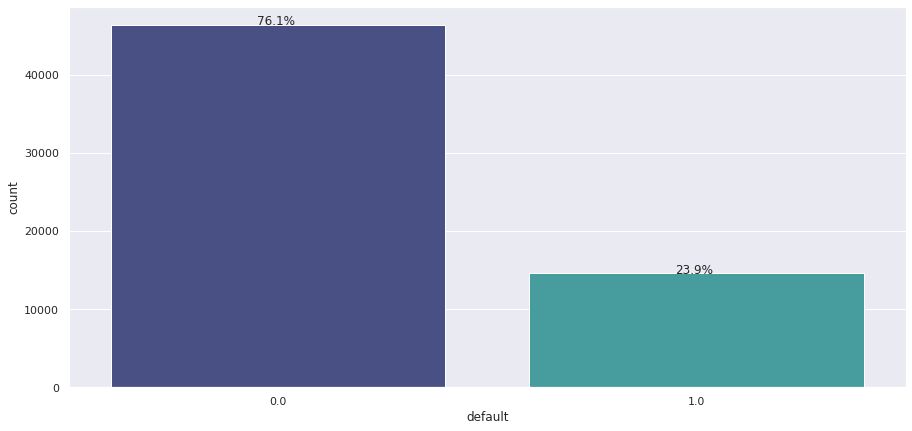

In [68]:
perc_on_bar(df.default)

### delinq_2yrs

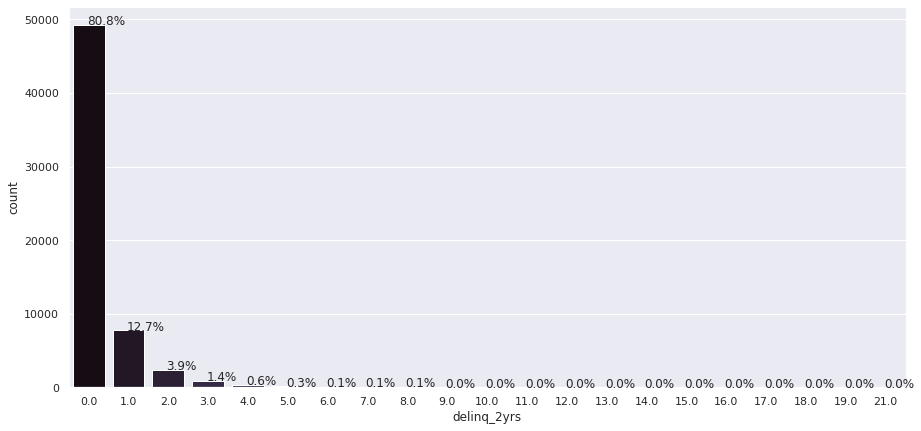

In [69]:
perc_on_bar(df.delinq_2yrs)

### public_records

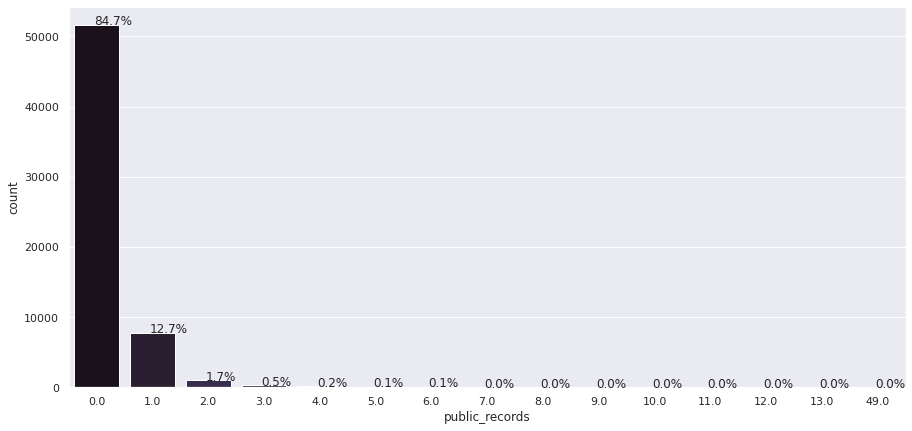

In [70]:
perc_on_bar(df.public_records)

### loan_term

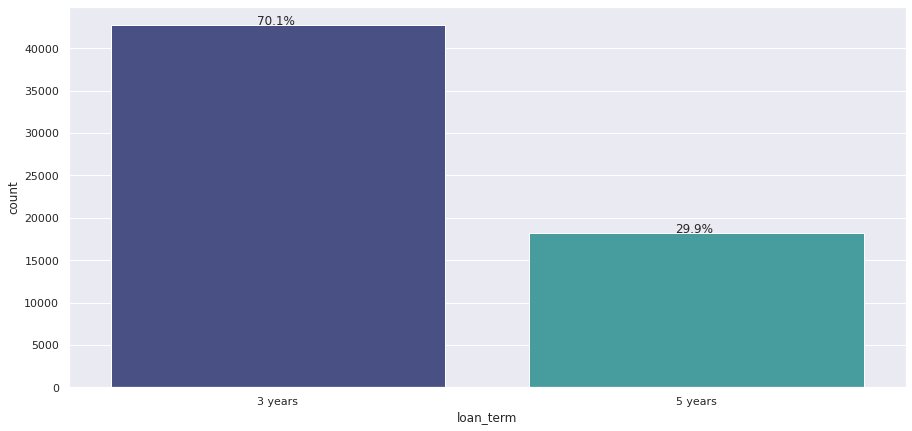

In [71]:
perc_on_bar(df.loan_term)

### loan_grade

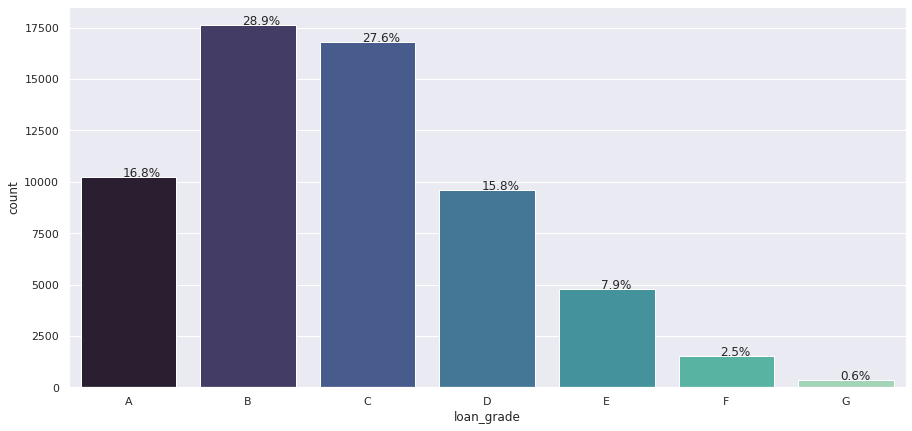

In [72]:
perc_on_bar(df.loan_grade)

### loan_subgrade

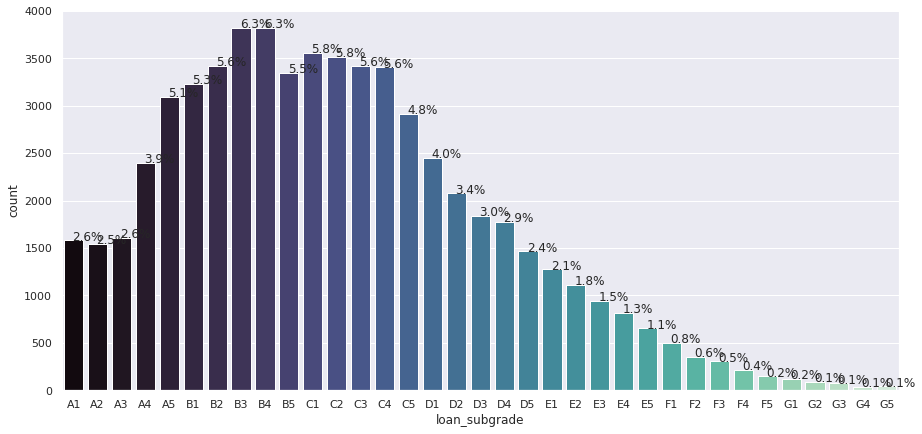

In [73]:
perc_on_bar(df.loan_subgrade)

### job_experience

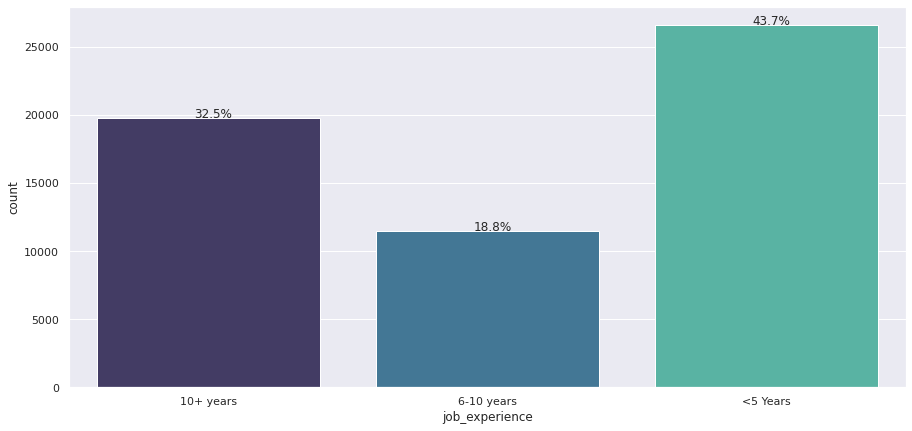

In [74]:
perc_on_bar(df.job_experience)

### home_ownership

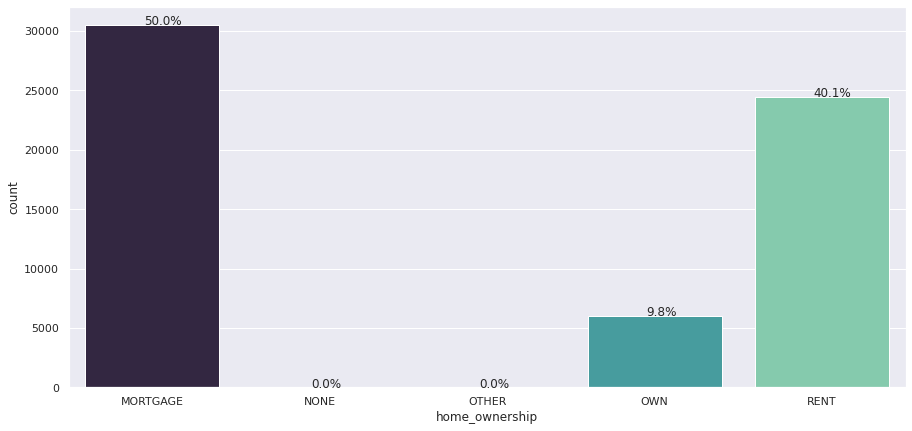

In [75]:
perc_on_bar(df.home_ownership)

### income_verification_status

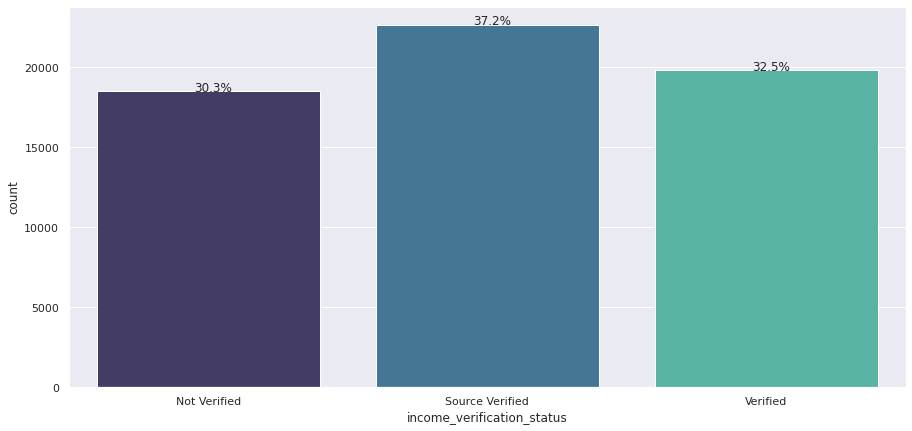

In [76]:
perc_on_bar(df.income_verification_status)

### loan_purpose

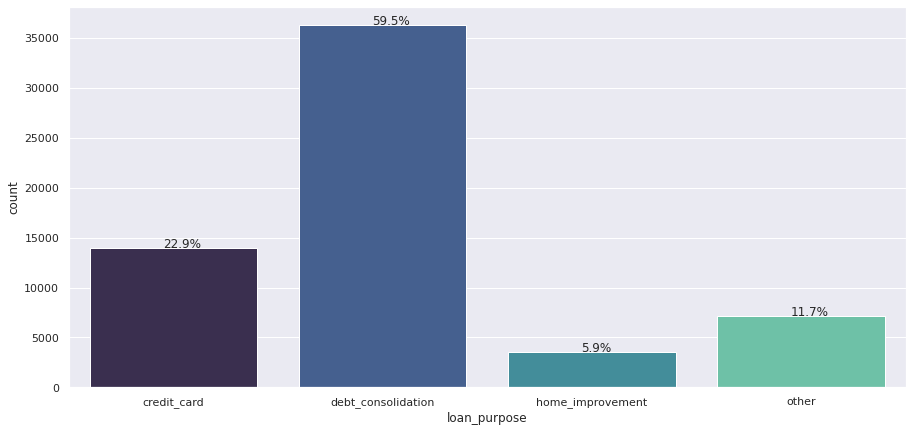

In [77]:
perc_on_bar(df.loan_purpose)

### state_code

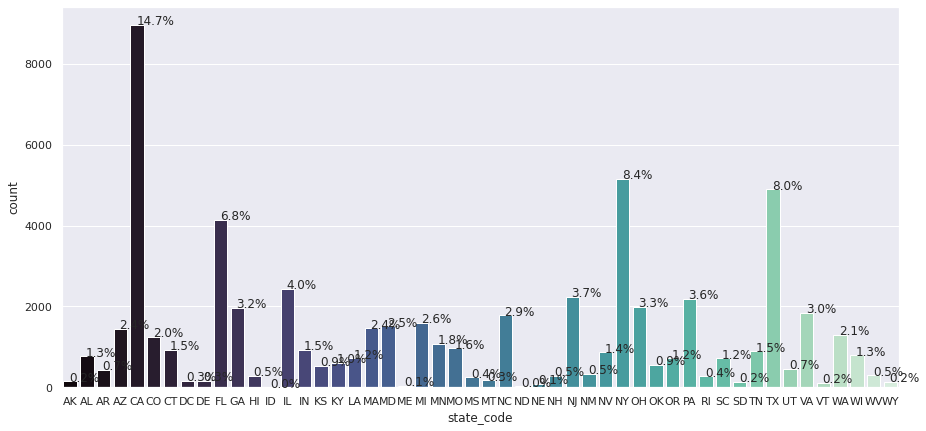

In [78]:
perc_on_bar(df.state_code)

### application_type

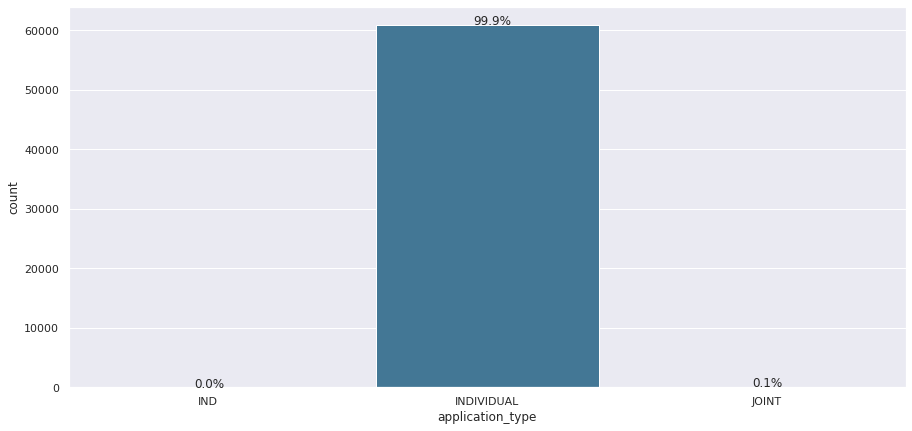

In [79]:
perc_on_bar(df.application_type)

### Bivariate Analysis

In [80]:
## Function to plot stacked bar chart
def stacked_plot(x, y, show_df=True):
    """
    Shows stacked plot from x and y pandas data series
    x: pandas data series
    y: pandas data series
    show_df: flag to show dataframe above plot (default=True)
    """
    if show_df == True:
        info = pd.crosstab(x, y, margins=True)
        info['% - 0'] = round(info[0]/info['All']*100, 2)
        info['% - 1'] = round(info[1]/info['All']*100, 2)
        display(info)
        
    pd.crosstab(x, y, normalize='index').plot(kind='bar', stacked=True, figsize=(10,5));

In [81]:
def show_boxplots(cols: list, feature: str, show_fliers=True, data=df): #method call to show bloxplots
    """
    Shows boxplots from pandas data series
    cols: list of column names
    feature: dataframe categorical feature
    """
    n_rows = math.ceil(len(cols)/3)
    plt.figure(figsize=(15, n_rows*5))
    for i, variable in enumerate(cols):
        plt.subplot(n_rows, 3, i+1)
        if show_fliers:
            sns.boxplot(data[feature], data[variable], palette="mako", showfliers=True) 
        else:
            sns.boxplot(data[feature], data[variable], palette="mako", showfliers=False)
        plt.tight_layout()
        plt.title(variable, fontsize=12)
    plt.show()

In [82]:
### Function to plot distributions and Boxplots of customers
def plot_target(x, target='default'):
    fig,axs = plt.subplots(2,2,figsize=(12,10))
    axs[0, 0].set_title('Distribution of DEFAULT')
    sns.distplot(data[(data[target] == 1)][x], ax=axs[0,0], color='teal')
    axs[0, 1].set_title('Distribution of NON-DEFAULT')
    sns.distplot(data[(data[target] == 0)][x],ax=axs[0,1], color='orange')
    axs[1,0].set_title('Boxplot w.r.t default-flag')
    sns.boxplot(data[target],data[x],ax=axs[1,0], palette='mako')
    axs[1,1].set_title('Boxplot w.r.t default-flag - Without outliers')
    sns.boxplot(data[target],data[x], ax=axs[1,1], showfliers=False, palette='mako')
    plt.tight_layout()
    plt.show()

### Heat map

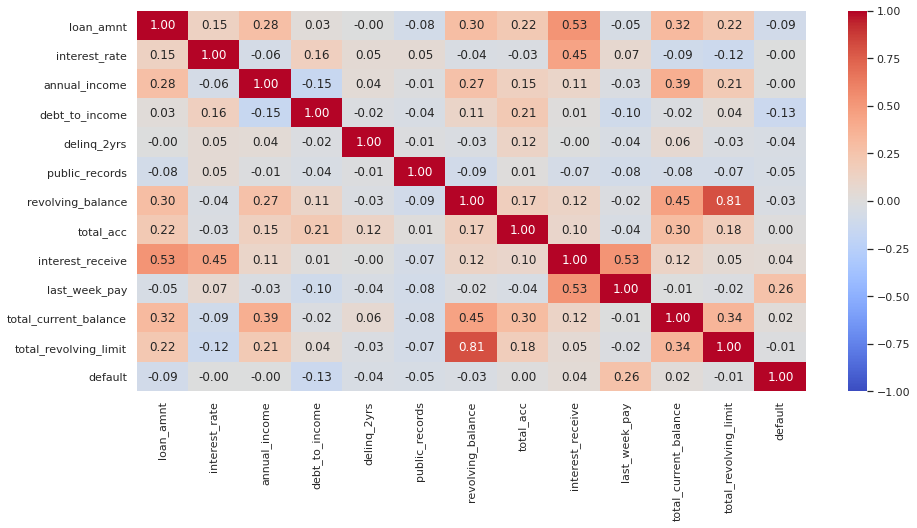

In [83]:
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(),annot=True,vmin=-1,vmax=1,fmt='.2f',cmap='coolwarm');

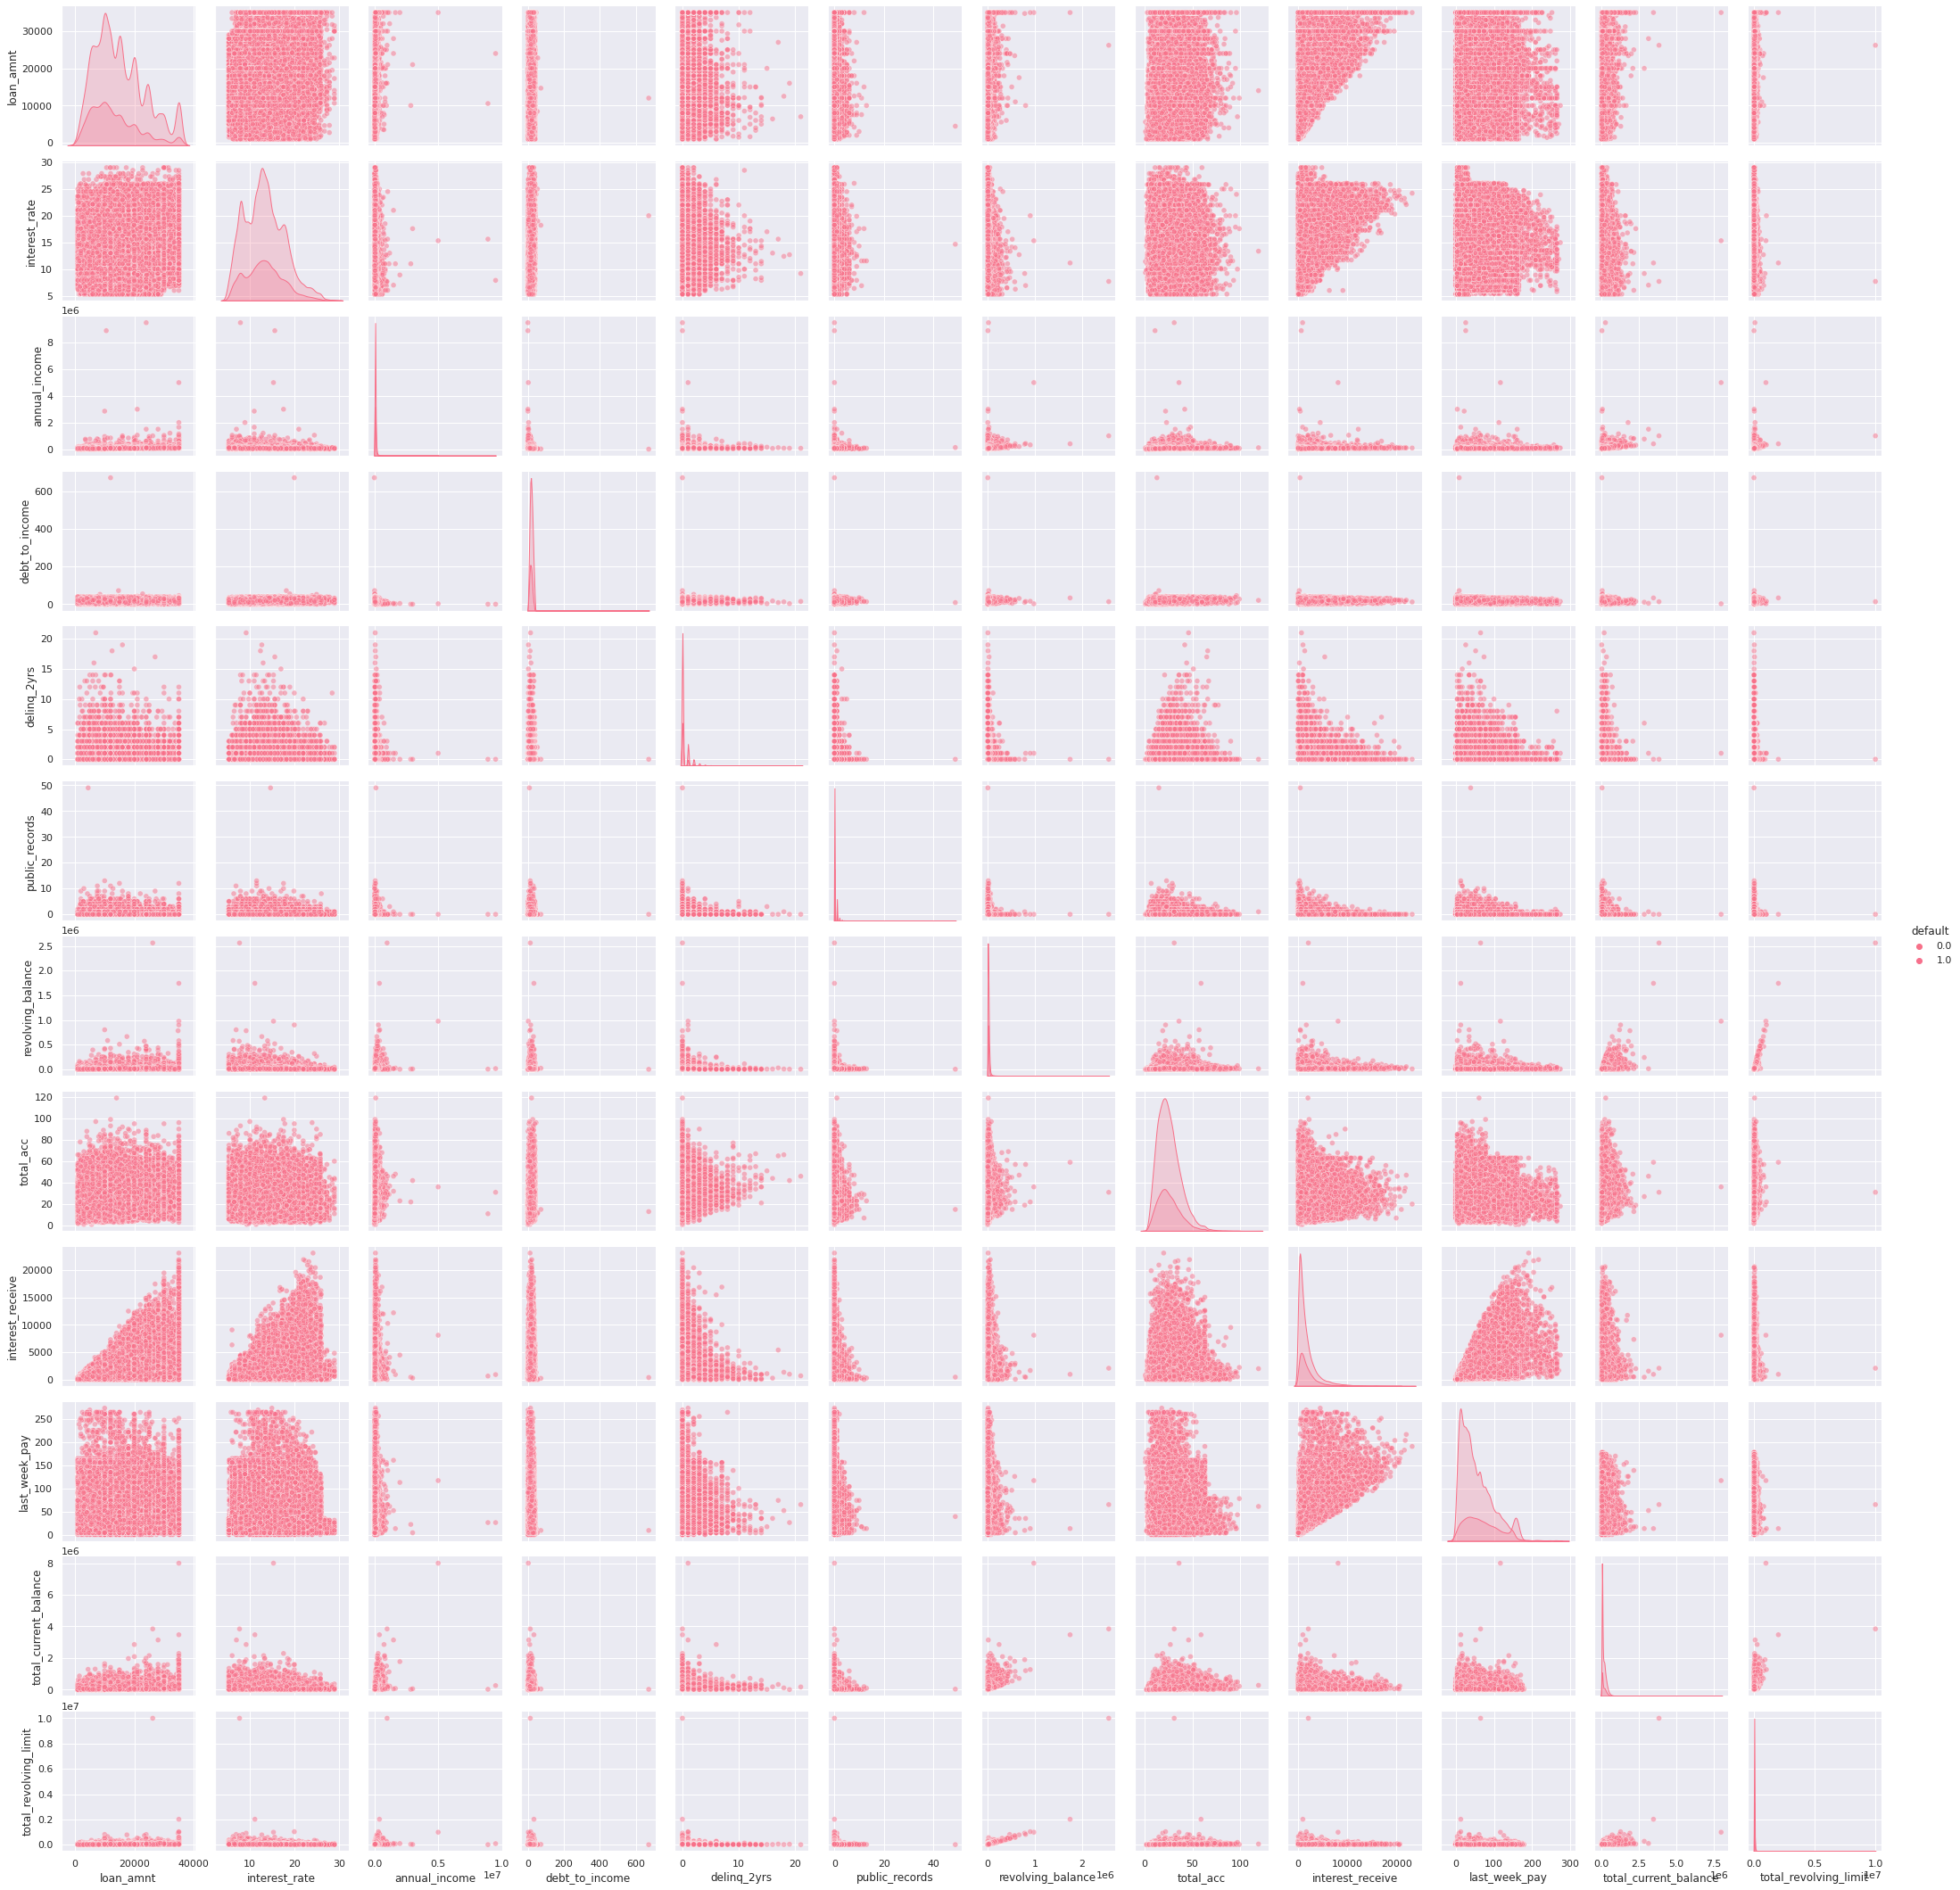

In [84]:
sns.pairplot(
    data=df, 
    hue='default',
    palette='husl',
    plot_kws={'alpha': 0.5}
);

### default vs loan_term

default      0.0    1.0    All  % - 0  % - 1
loan_term                                   
3 years    30984  11775  42759 72.460 27.540
5 years    15408   2805  18213 84.600 15.400
All        46392  14580  60972 76.090 23.910

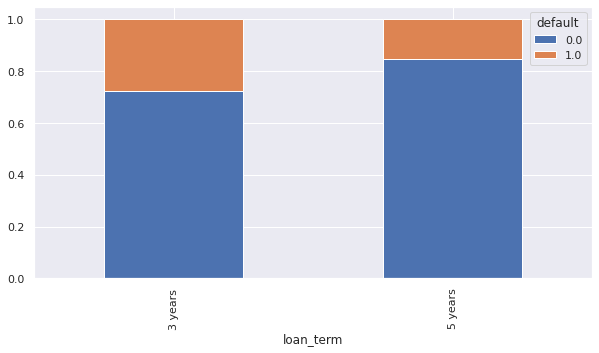

In [85]:
stacked_plot(df.loan_term, df.default)

### default vs loan_grade

default       0.0    1.0    All  % - 0  % - 1
loan_grade                                   
A            7402   2832  10234 72.330 27.670
B           12966   4667  17633 73.530 26.470
C           13135   3673  16808 78.150 21.850
D            7467   2139   9606 77.730 22.270
E            3913    889   4802 81.490 18.510
F            1226    298   1524 80.450 19.550
G             283     82    365 77.530 22.470
All         46392  14580  60972 76.090 23.910

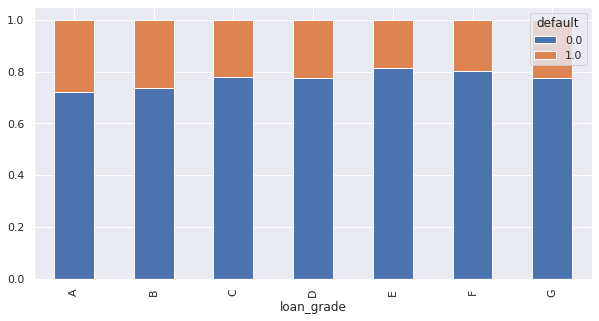

In [86]:
stacked_plot(df.loan_grade, df.default)

### default vs loan_subgrade

default          0.0    1.0    All  % - 0  % - 1
loan_subgrade                                   
A1              1193    389   1582 75.410 24.590
A2              1106    441   1547 71.490 28.510
A3              1146    465   1611 71.140 28.860
A4              1631    770   2401 67.930 32.070
A5              2326    767   3093 75.200 24.800
B1              2454    774   3228 76.020 23.980
B2              2466    950   3416 72.190 27.810
B3              2729   1092   3821 71.420 28.580
B4              2819   1002   3821 73.780 26.220
B5              2498    849   3347 74.630 25.370
C1              2728    829   3557 76.690 23.310
C2              2730    785   3515 77.670 22.330
C3              2676    741   3417 78.310 21.690
C4              2712    692   3404 79.670 20.330
C5              2289    626   2915 78.520 21.480
D1              1924    525   2449 78.560 21.440
D2              1573    503   2076 75.770 24.230
D3              1398    438   1836 76.140 23.860
D4              1401    378   1779 78.750 21.250
D5              1171    295   1466 79.880 20.120
E1              1064    210   1274 83.520 16.480
E2               916    198   1114 82.230 17.770
E3               757    187    944 80.190 19.810
E4               661    157    818 80.810 19.190
E5               515    137    652 78.990 21.010
F1               404     97    501 80.640 19.360
F2               286     67    353 81.020 18.980
F3               241     65    306 78.760 21.240
F4               172     45    217 79.260 20.740
F5               123     24    147 83.670 16.330
G1                91     31    122 74.590 25.410
G2                73     18     91 80.220 19.780
G3                55     18     73 75.340 24.660
G4                30      8     38 78.950 21.050
G5                34      7     41 82.930 17.070
All            46392  14580  60972 76.090 23.910

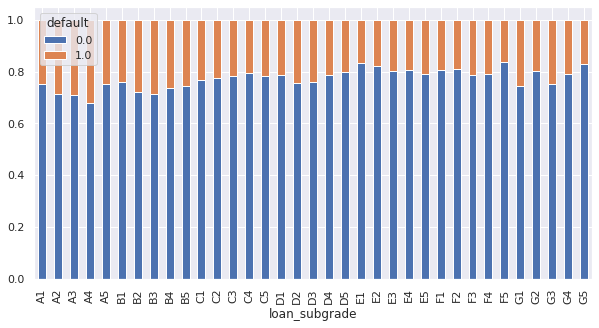

In [87]:
stacked_plot(df.loan_subgrade, df.default)

### default vs job_experience

default           0.0    1.0    All  % - 0  % - 1
job_experience                                   
10+ years       15401   4392  19793 77.810 22.190
6-10 years       8589   2889  11478 74.830 25.170
<5 Years        19826   6790  26616 74.490 25.510
All             43816  14071  57887 75.690 24.310

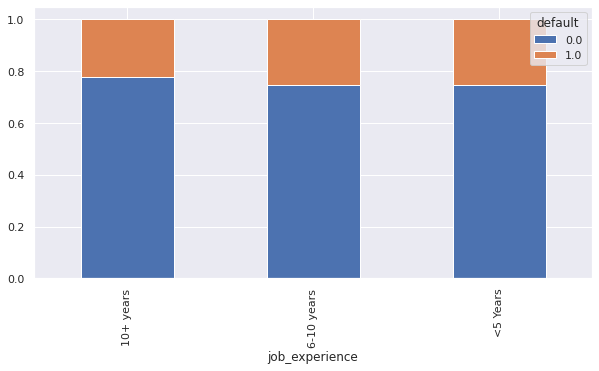

In [88]:
stacked_plot(df.job_experience, df.default)

### default vs home_ownership

default           0.0    1.0    All  % - 0  % - 1
home_ownership                                   
MORTGAGE        23114   7396  30510 75.760 24.240
NONE                2      4      6 33.330 66.670
OTHER               1      6      7 14.290 85.710
OWN              4760   1240   6000 79.330 20.670
RENT            18515   5934  24449 75.730 24.270
All             46392  14580  60972 76.090 23.910

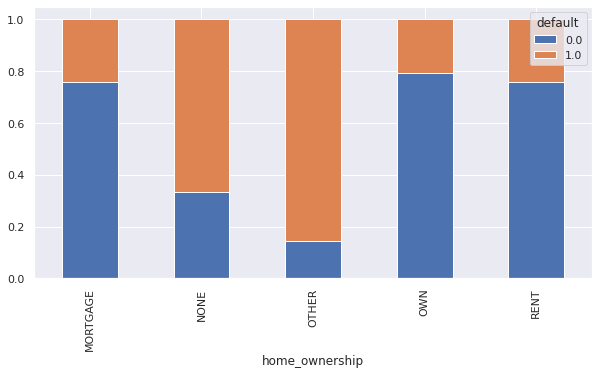

In [89]:
stacked_plot(df.home_ownership, df.default)

### default vs income_verification_status

default                       0.0    1.0    All  % - 0  % - 1
income_verification_status                                   
Not Verified                13314   5185  18499 71.970 28.030
Source Verified             18416   4237  22653 81.300 18.700
Verified                    14662   5158  19820 73.980 26.020
All                         46392  14580  60972 76.090 23.910

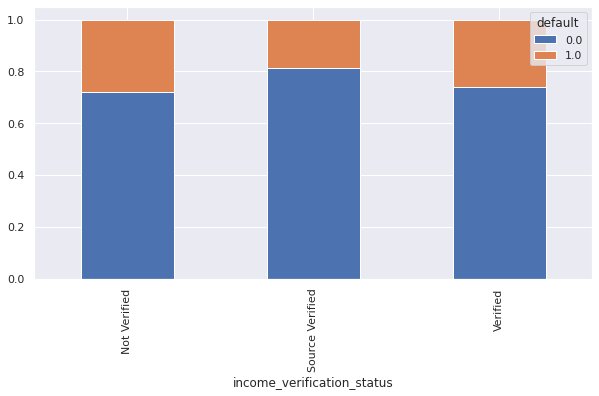

In [90]:
stacked_plot(df.income_verification_status, df.default)

### default vs loan_purpose


default               0.0    1.0    All  % - 0  % - 1
loan_purpose                                         
credit_card         10980   2968  13948 78.720 21.280
debt_consolidation  27779   8514  36293 76.540 23.460
home_improvement     2696    886   3582 75.270 24.730
other                4937   2212   7149 69.060 30.940
All                 46392  14580  60972 76.090 23.910

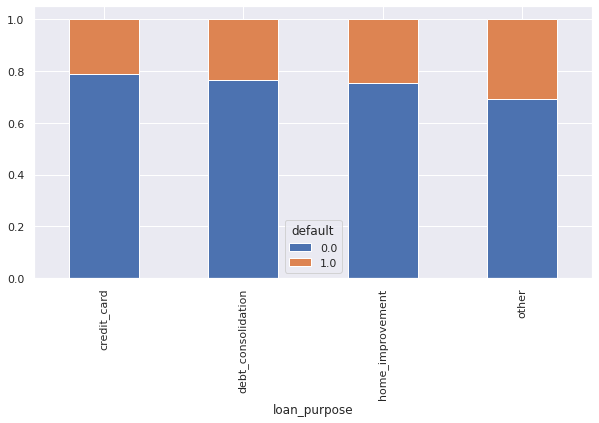

In [91]:
stacked_plot(df.loan_purpose, df.default)

### default vs state_code

default       0.0    1.0    All   % - 0   % - 1
state_code                                     
AK            100     45    145  68.970  31.030
AL            587    178    765  76.730  23.270
AR            338     89    427  79.160  20.840
AZ           1064    377   1441  73.840  26.160
CA           6479   2487   8966  72.260  27.740
CO            917    329   1246  73.600  26.400
CT            718    208    926  77.540  22.460
DC            106     54    160  66.250  33.750
DE            122     39    161  75.780  24.220
FL           3168    973   4141  76.500  23.500
GA           1534    429   1963  78.150  21.850
HI            216     69    285  75.790  24.210
ID              0      1      1   0.000 100.000
IL           1872    566   2438  76.780  23.220
IN            776    157    933  83.170  16.830
KS            407    118    525  77.520  22.480
KY            471    135    606  77.720  22.280
LA            560    158    718  77.990  22.010
MA           1061    402   1463  72.520  27.480
MD           1148    359   1507  76.180  23.820
ME             34      2     36  94.440   5.560
MI           1263    337   1600  78.940  21.060
MN            835    244   1079  77.390  22.610
MO            731    234    965  75.750  24.250
MS            225     18    243  92.590   7.410
MT            137     37    174  78.740  21.260
NC           1374    410   1784  77.020  22.980
ND             27      0     27 100.000   0.000
NE             81      2     83  97.590   2.410
NH            203     76    279  72.760  27.240
NJ           1679    554   2233  75.190  24.810
NM            252     77    329  76.600  23.400
NV            633    233    866  73.090  26.910
NY           3886   1266   5152  75.430  24.570
OH           1588    407   1995  79.600  20.400
OK            426    129    555  76.760  23.240
OR            539    179    718  75.070  24.930
PA           1727    467   2194  78.710  21.290
RI            205     66    271  75.650  24.350
SC            547    172    719  76.080  23.920
SD            100     35    135  74.070  25.930
TN            751    138    889  84.480  15.520
TX           3781   1119   4900  77.160  22.840
UT            320    131    451  70.950  29.050
VA           1396    442   1838  75.950  24.050
VT             81     34    115  70.430  29.570
WA            959    336   1295  74.050  25.950
WI            631    166    797  79.170  20.830
WV            230     64    294  78.230  21.770
WY            107     32    139  76.980  23.020
All         46392  14580  60972  76.090  23.910

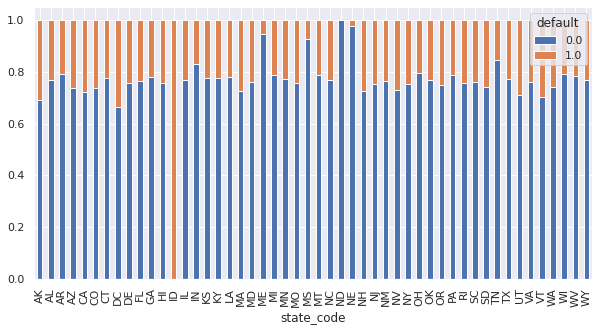

In [92]:
stacked_plot(df.state_code, df.default)

 With outliers 
 **************************************************


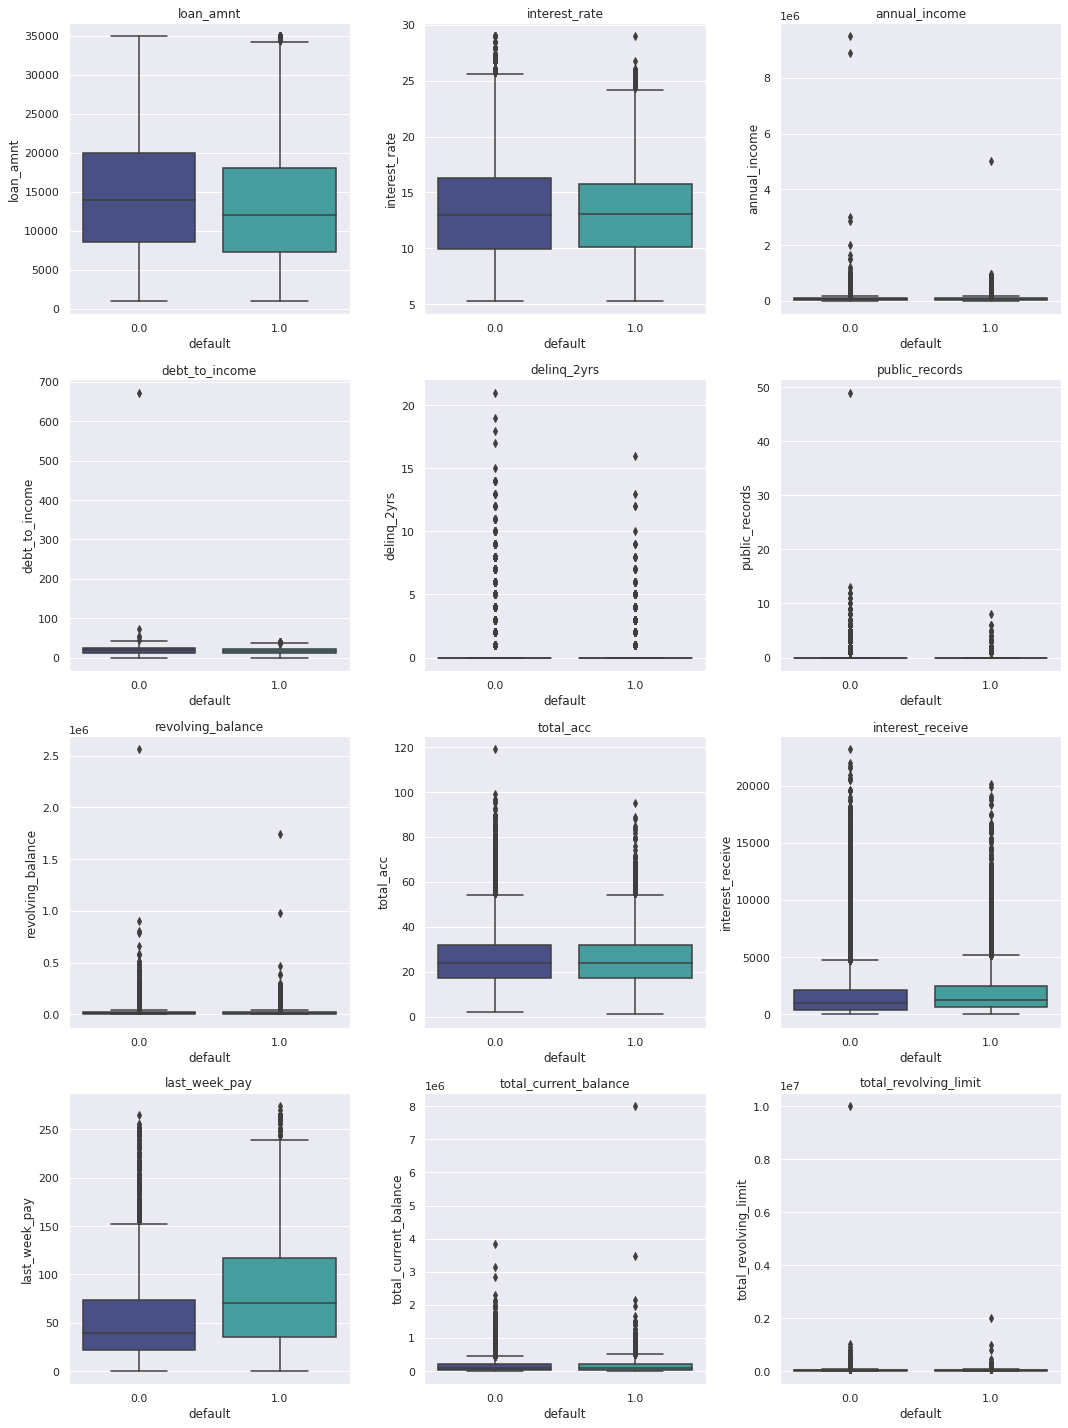

In [93]:
cols = df.select_dtypes(include=['integer', 'float']).columns.tolist()
cols.remove('default')
print(' With outliers','\n','*'*50)
show_boxplots(cols=cols, feature='default')

 Without outliers 
 **************************************************


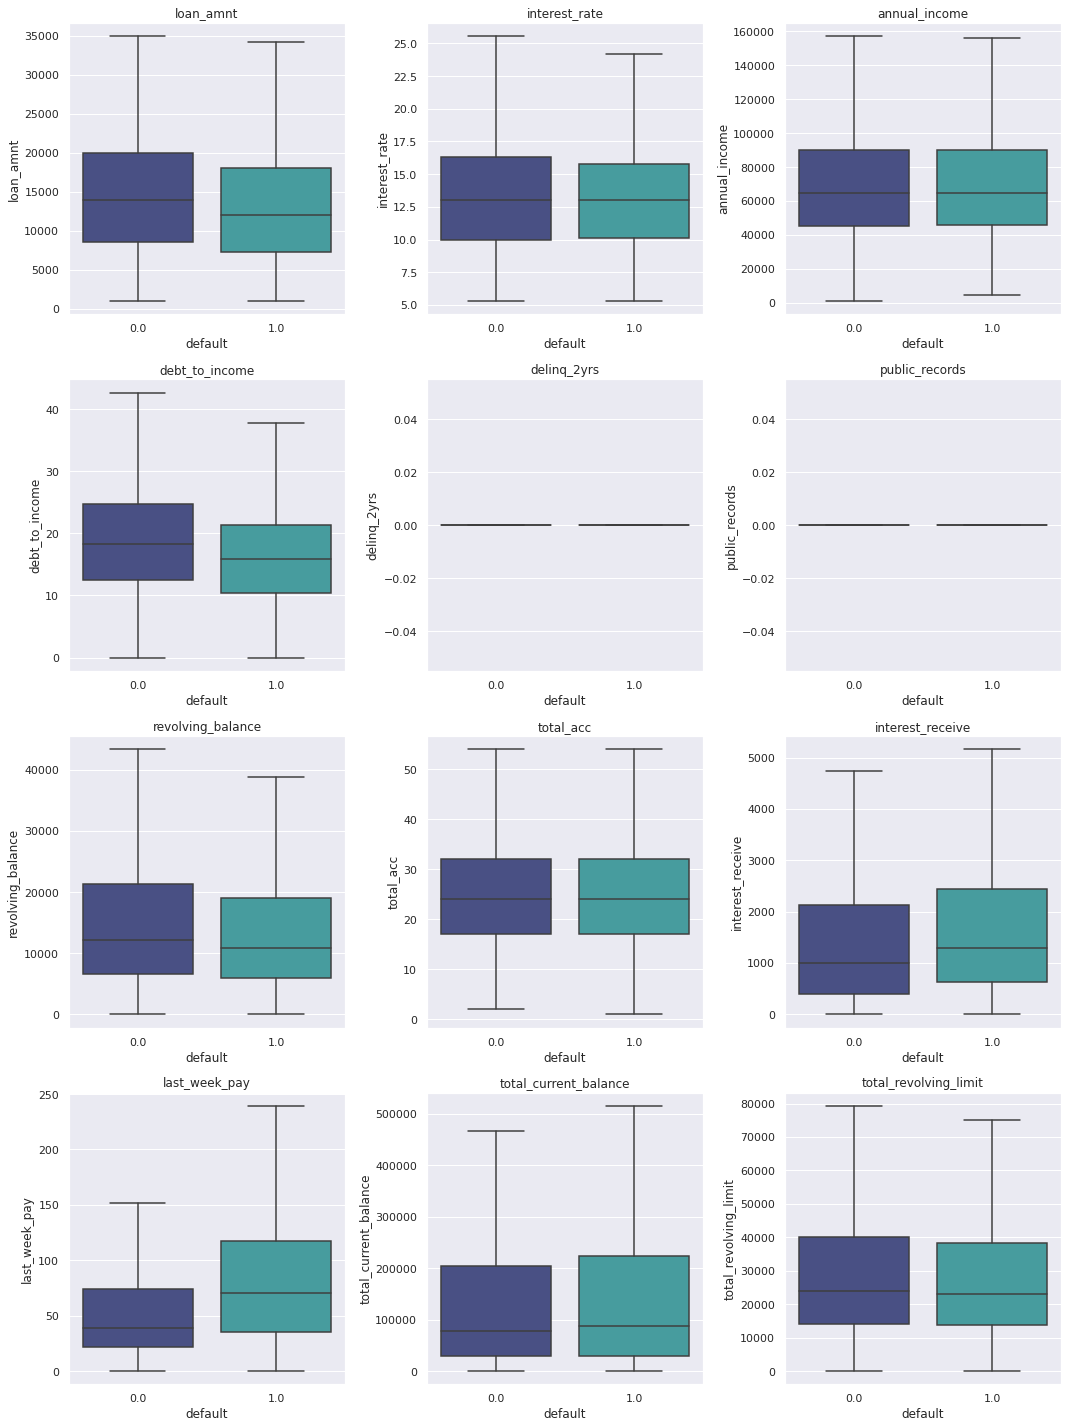

In [94]:
print(' Without outliers','\n','*'*50)
show_boxplots(cols=cols, feature='default', show_fliers=False)

### default vs loan_amnt

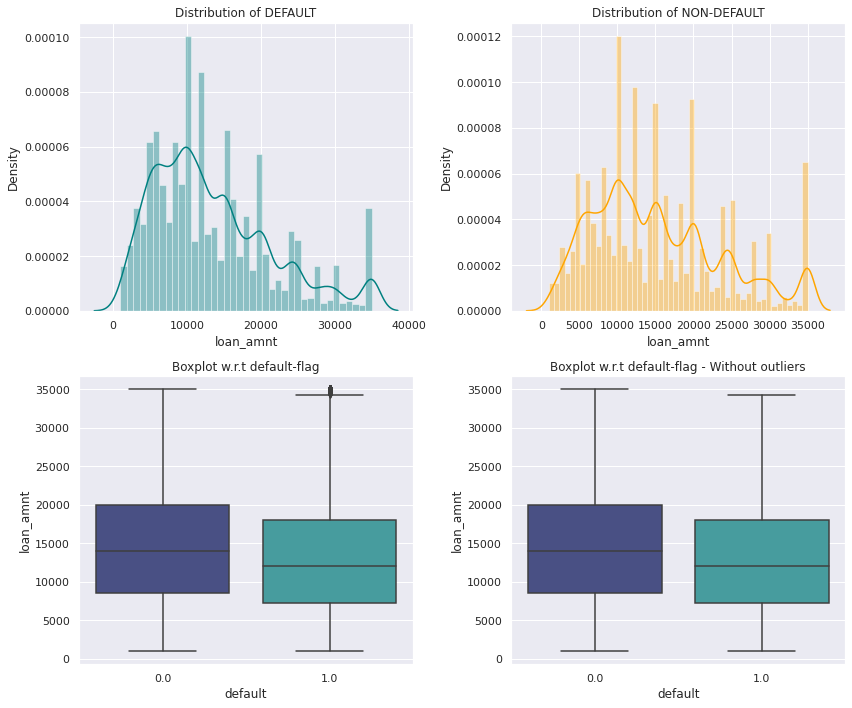

In [95]:
plot_target('loan_amnt')

### default vs interest_rate

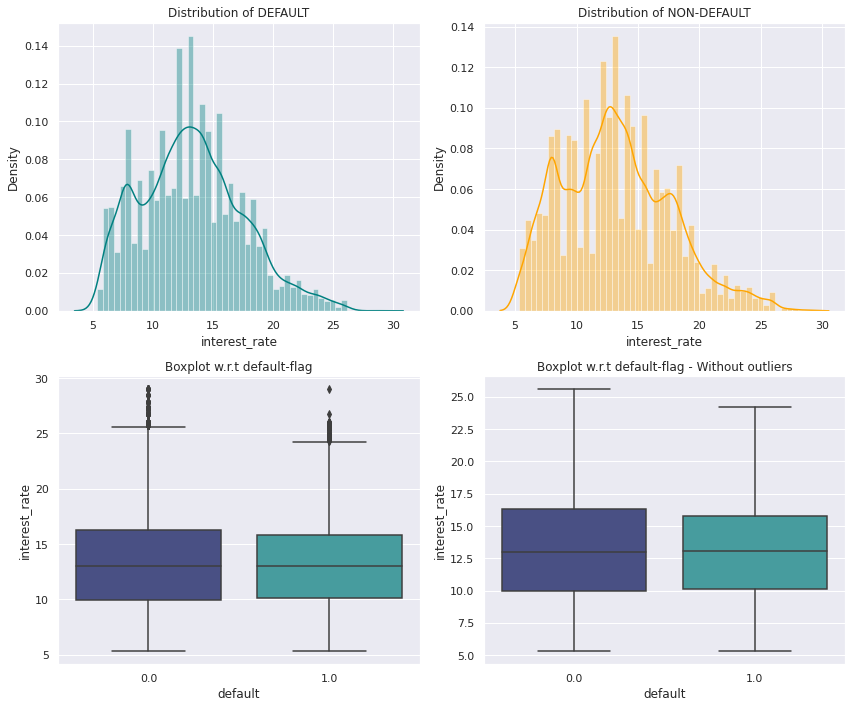

In [96]:
plot_target('interest_rate')

### default vs annual_income

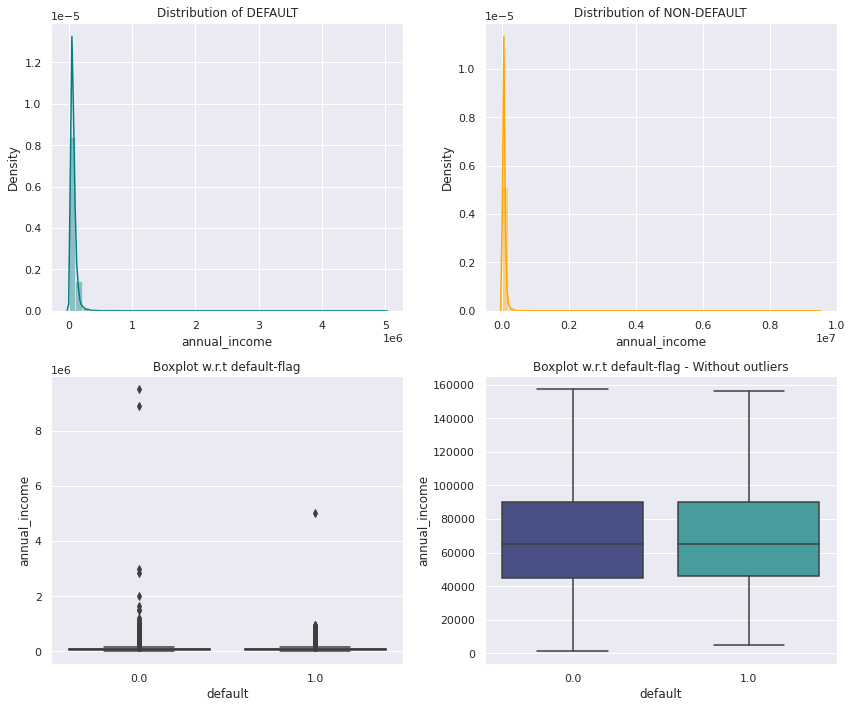

In [97]:
plot_target('annual_income')

### default vs debt_to_income

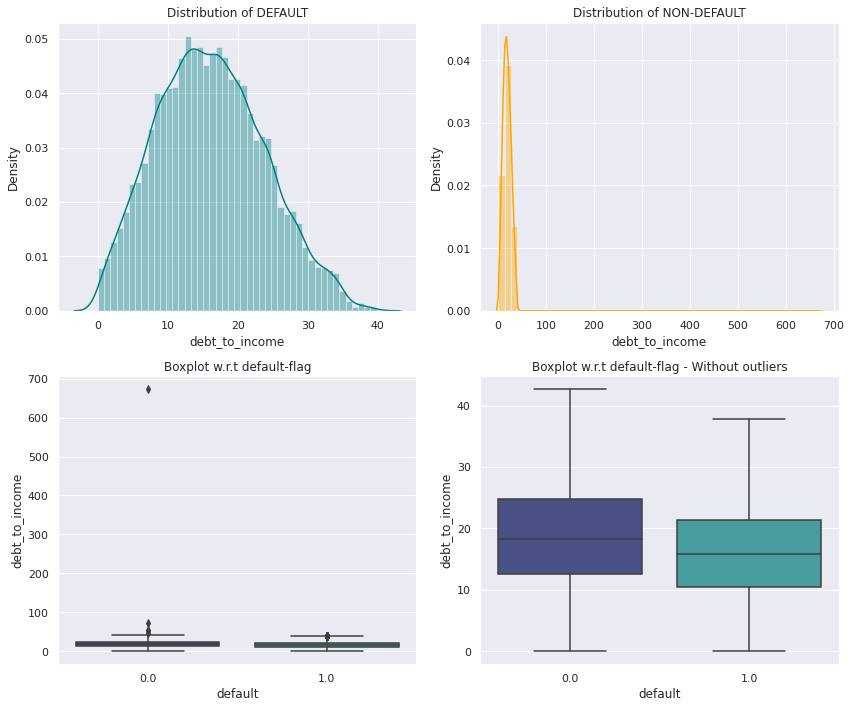

In [98]:
plot_target('debt_to_income')

### default vs delinq_2yrs

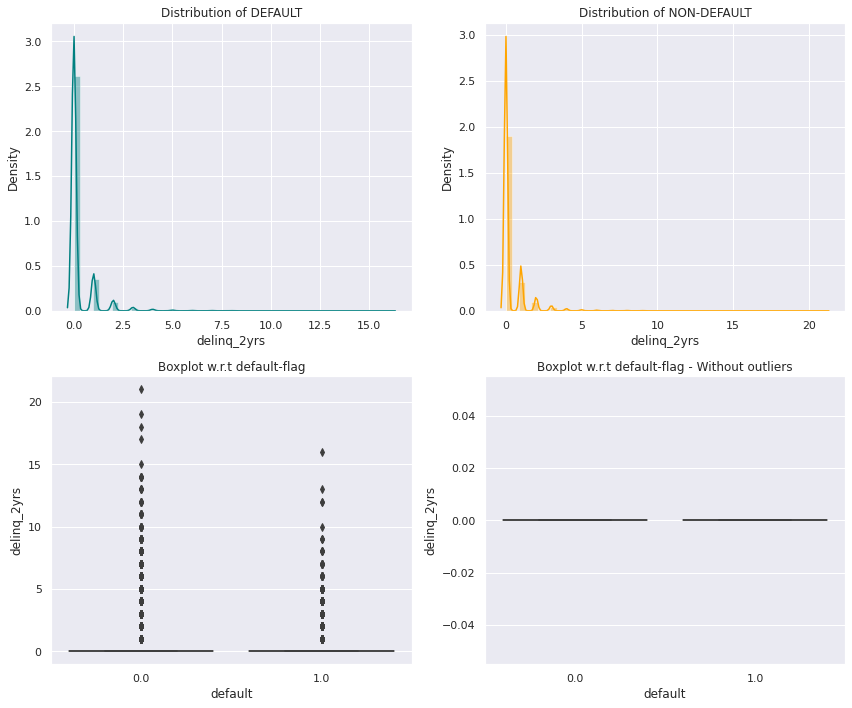

In [99]:
plot_target('delinq_2yrs')

### default vs public_records

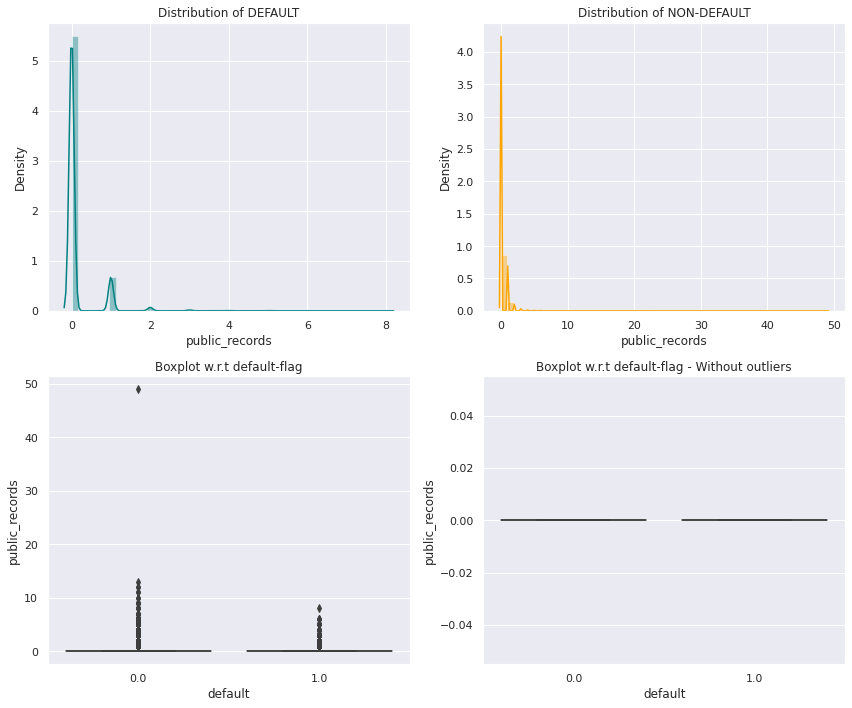

In [100]:
plot_target('public_records')

### default vs revolving_balance

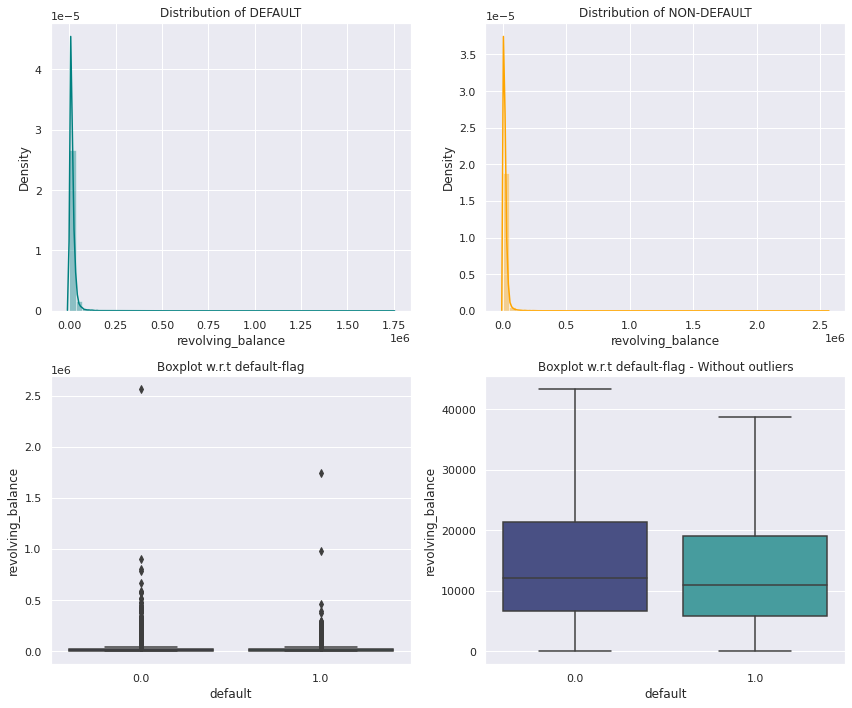

In [101]:
plot_target('revolving_balance')

### default vs total_acc

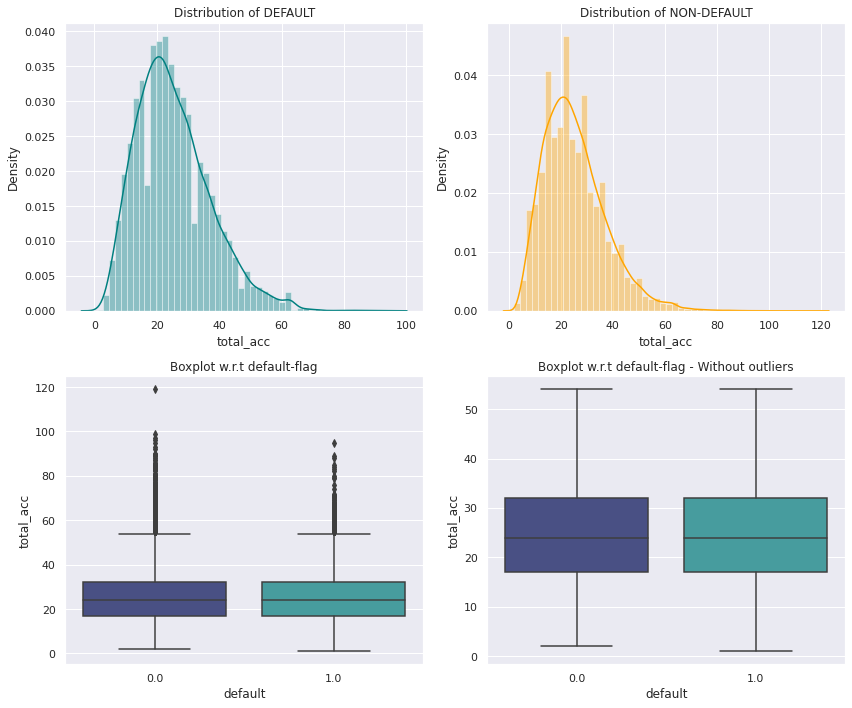

In [102]:
plot_target('total_acc')

### default vs interest_receive

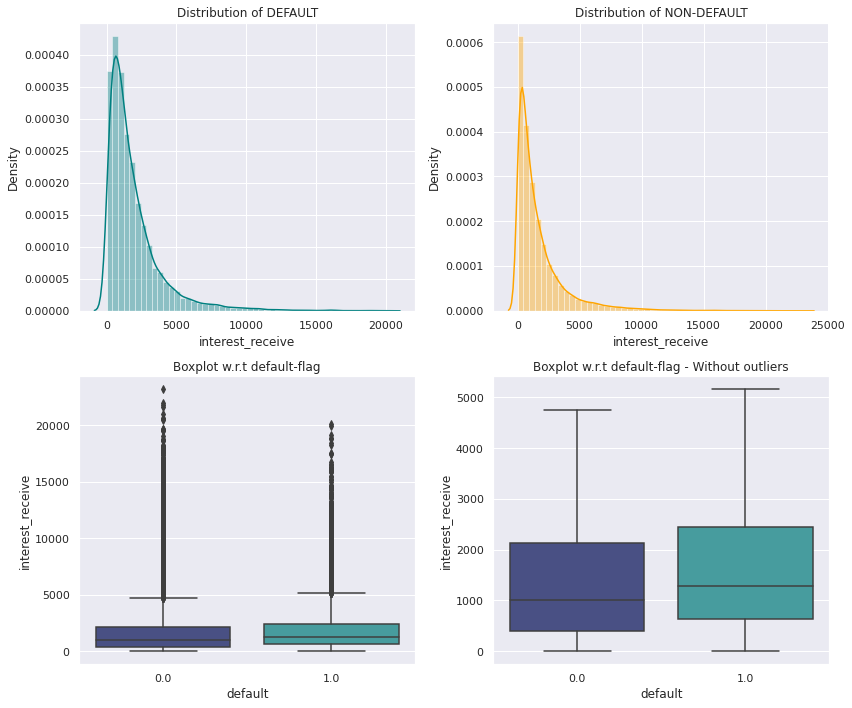

In [103]:
plot_target('interest_receive')

### default vs last_week_pay

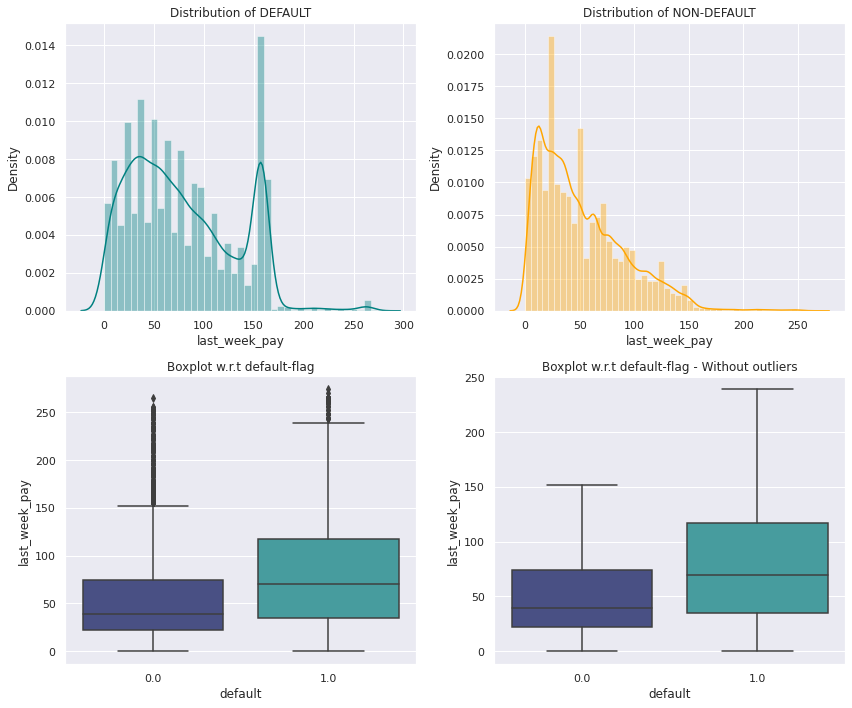

In [104]:
plot_target('last_week_pay')

### default vs total_current_balance

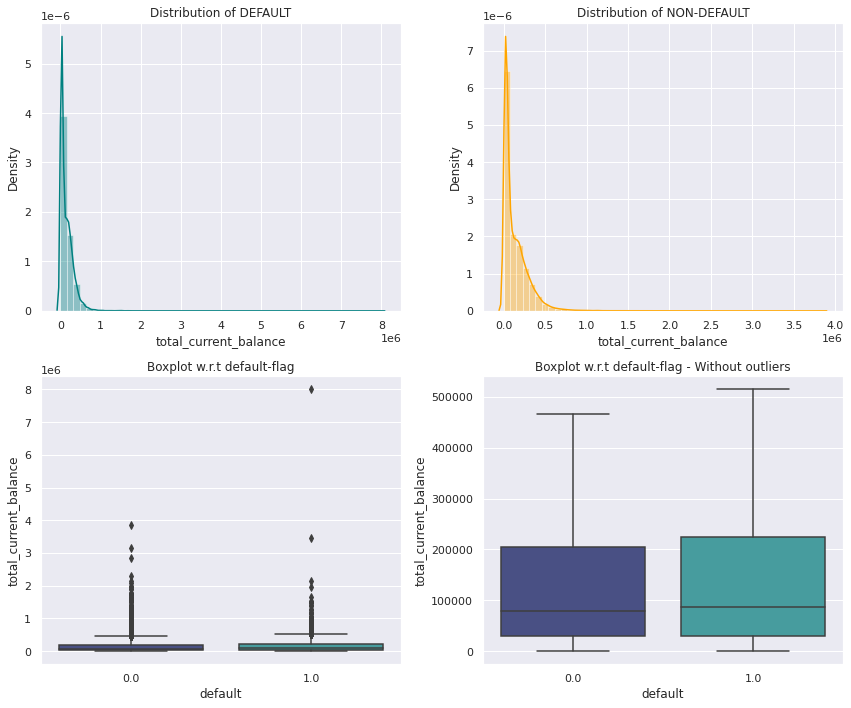

In [105]:
plot_target('total_current_balance')

### default vs total_revolving_limit

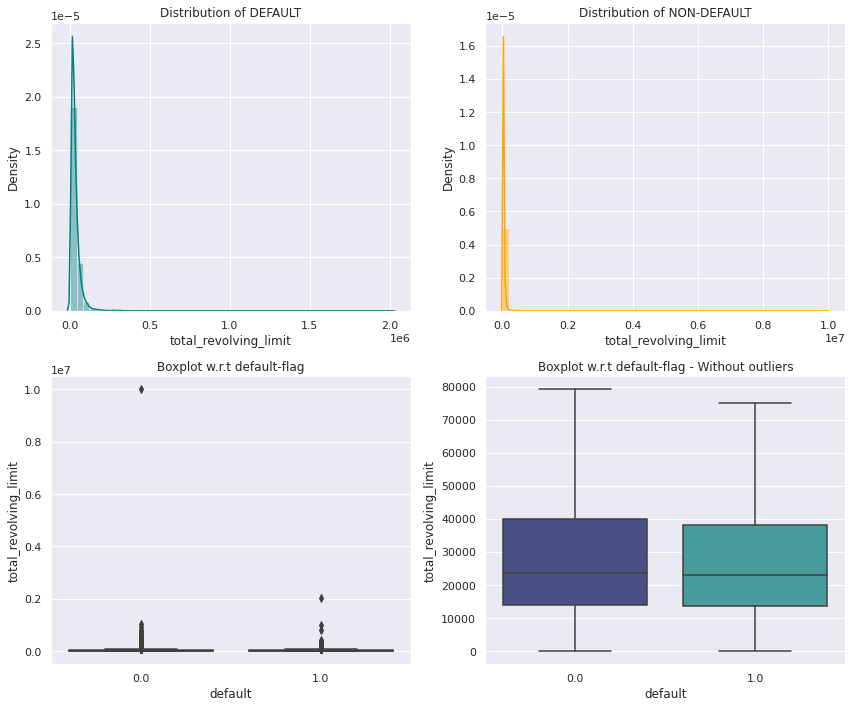

In [106]:
plot_target('total_revolving_limit')

In [107]:
def show_violinplot(cols: list, feature: str, hue=df.default, data=df, show_fliers=True):
    #plt.figure(figsize=(12,10))
    for i, variable in enumerate(cols):
        plt.subplot(2, 2, i+1)
        sns.violinplot(data[feature], 
                       data[variable],
                       hue=hue,
                       ci=0,
                       show_fliers=show_fliers)
        plt.tight_layout()
        plt.title(variable);

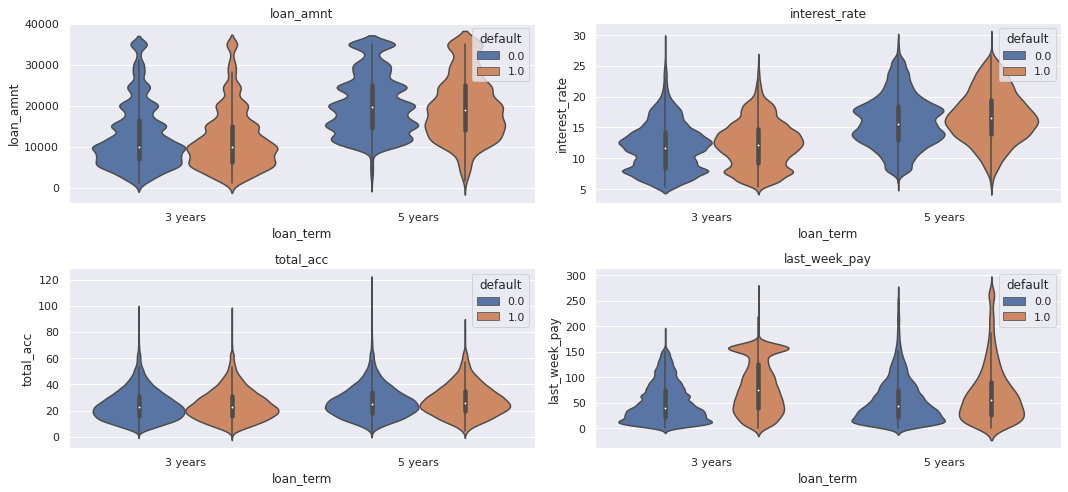

In [108]:
cols = ['loan_amnt', 'interest_rate', 'total_acc', 'last_week_pay']
show_violinplot(cols, 'loan_term')

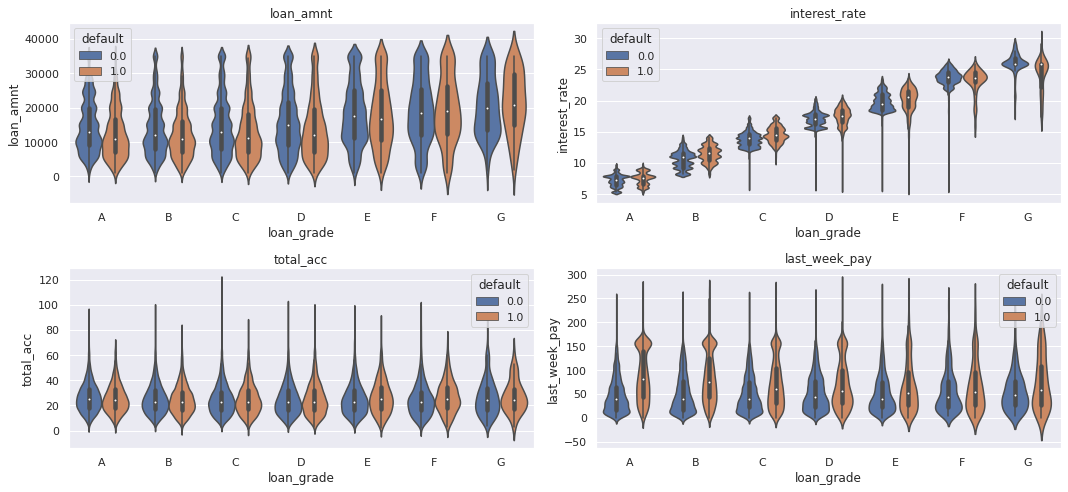

In [109]:
show_violinplot(cols, 'loan_grade', show_fliers=False)

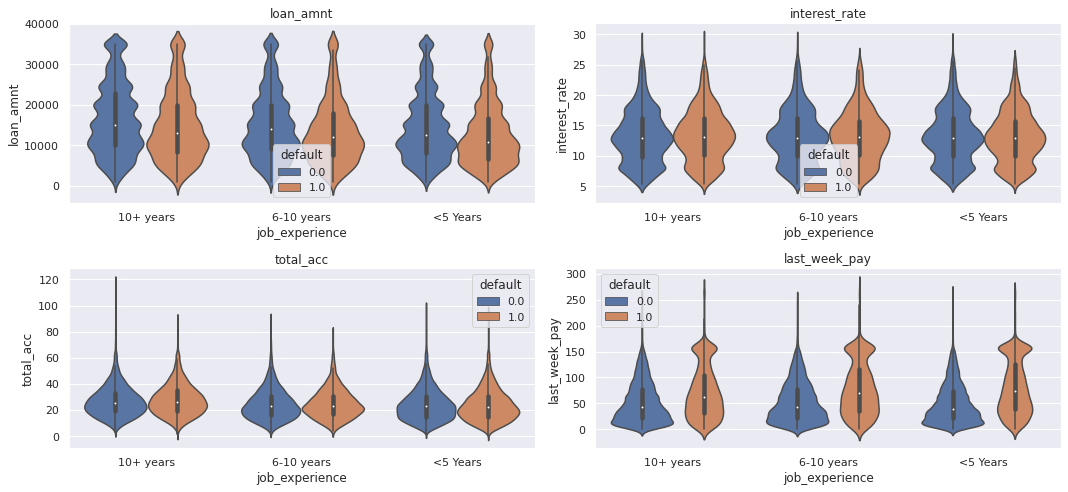

In [110]:
show_violinplot(cols, 'job_experience', show_fliers=False)

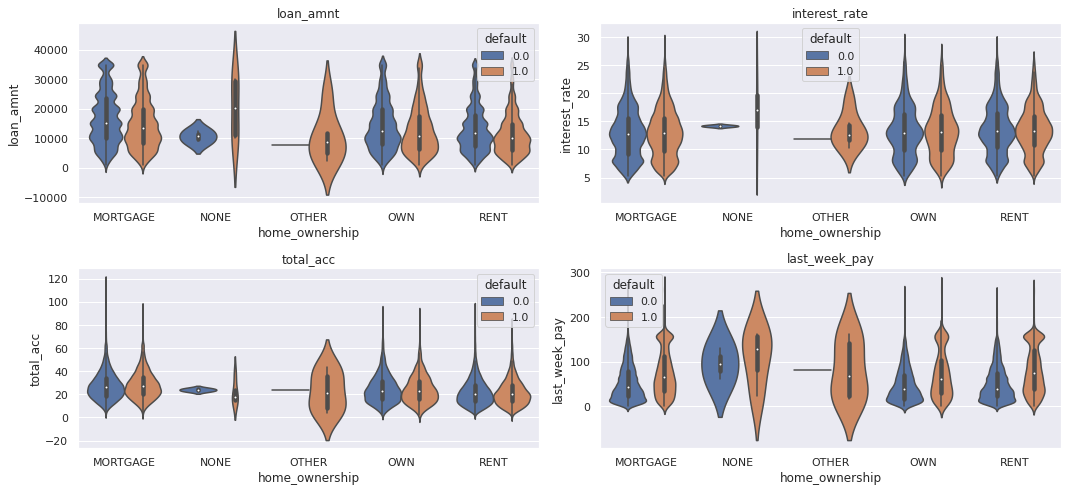

In [111]:
show_violinplot(cols, 'home_ownership', show_fliers=False)

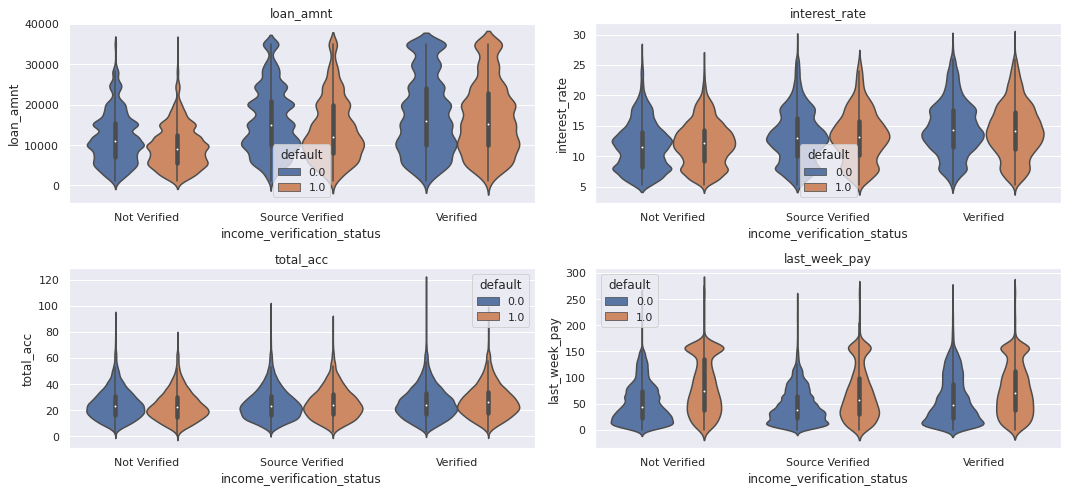

In [112]:
show_violinplot(cols, 'income_verification_status', show_fliers=False)

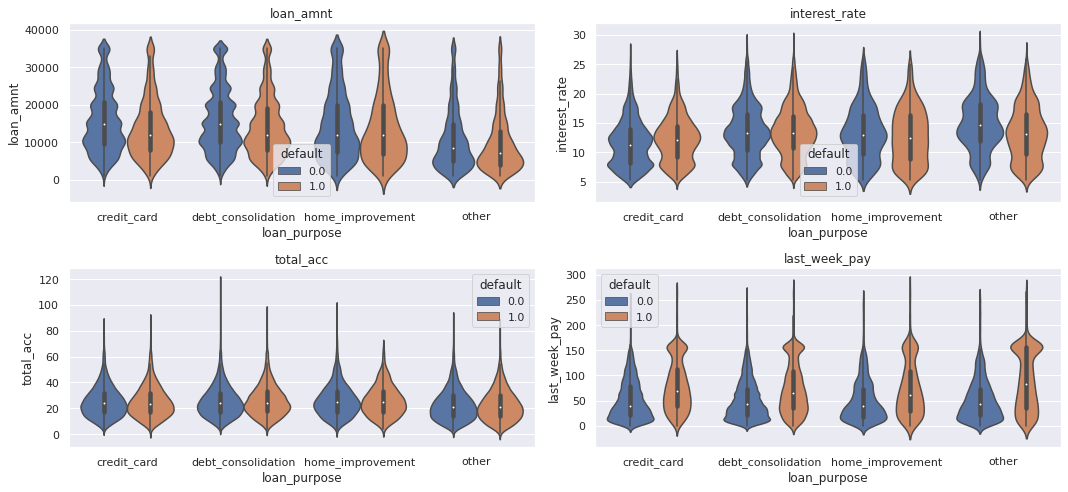

In [113]:
show_violinplot(cols, 'loan_purpose', show_fliers=False)

In [114]:
Q1 = data.quantile(0.25) # To find the 25th percentile and 75th percentile.
Q3 = data.quantile(0.75)
IQR = Q3 - Q1            # Inter Quantile Range (75th perentile - 25th percentile)
lower = Q1-1.5 * IQR     # Finding lower and upper bounds for all values. All values outside these bounds are outliers
upper = Q3+1.5 * IQR
df_lower = (data.select_dtypes(include=['float64','int64']) < lower)
df_upper = (data.select_dtypes(include=['float64','int64']) > upper)
(df_lower | df_upper).sum()/len(data)*100

ID                       0.000
loan_amnt                0.000
interest_rate            0.651
annual_income            4.533
debt_to_income           0.011
delinq_2yrs             19.241
public_records          15.292
revolving_balance        5.416
total_acc                2.094
interest_receive         7.141
last_week_pay            0.738
total_current_balance    3.146
total_revolving_limit    5.345
default                 23.912
dtype: float64

<a id=processing></a>
## <span style="color:blue">Data Preparation</span>
<div style="text-align:right"><a href=#top>top</a></div>

In [115]:
df.isnull().sum()

loan_amnt                        0
loan_term                        0
interest_rate                    0
loan_grade                       0
loan_subgrade                    0
job_experience                3085
home_ownership                   0
annual_income                    0
income_verification_status       0
loan_purpose                     0
state_code                       0
debt_to_income                   0
delinq_2yrs                      0
public_records                   0
revolving_balance                0
total_acc                        0
interest_receive                 0
application_type                 0
last_week_pay                 1238
total_current_balance         4801
total_revolving_limit         4801
default                          1
dtype: int64

In [116]:
for i in df.select_dtypes(include=['category']).columns:
    print('Unique values in', i, 'are :')
    print(df[i].value_counts(dropna=False))
    print('*'*50)

Unique values in loan_term are :
3 years    42760
5 years    18213
Name: loan_term, dtype: int64
**************************************************
Unique values in loan_grade are :
B    17634
C    16808
A    10234
D     9606
E     4802
F     1524
G      365
Name: loan_grade, dtype: int64
**************************************************
Unique values in loan_subgrade are :
B4    3821
B3    3821
C1    3557
C2    3515
B2    3417
C3    3417
C4    3404
B5    3347
B1    3228
A5    3093
C5    2915
D1    2449
A4    2401
D2    2076
D3    1836
D4    1779
A3    1611
A1    1582
A2    1547
D5    1466
E1    1274
E2    1114
E3     944
E4     818
E5     652
F1     501
F2     353
F3     306
F4     217
F5     147
G1     122
G2      91
G3      73
G5      41
G4      38
Name: loan_subgrade, dtype: int64
**************************************************
Unique values in job_experience are :
<5 Years      26616
10+ years     19794
6-10 years    11478
NaN            3085
Name: job_experience, dtype: int64

In [117]:
# df1.home_ownership.replace('NONE','OTHER', inplace=True)
# df1.home_ownership.value_counts().sort_values(ascending=False)

In [118]:
# df1.income_verification_status.replace('Source Verified','Verified', inplace=True)
# df1.income_verification_status.value_counts().sort_values(ascending=False)

In [119]:
# df1['state_code'] = df1['state_code'].apply(region_combining)
# df1['state_code'] = df1['state_code'].astype('category')
# df1.state_code.value_counts(dropna=False)

#midwest = ['IA', 'IL', 'IN', 'KS', 'MI', 'MN', 'MO', 'ND', 'NE', 'OH', 'SD', 'WI']
#northeast = ['CT', 'MA', 'ME', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT']
#south = ['AL', 'AR', 'DC', 'DE', 'FL', 'GA', 'KY', 'LA', 'MD', 'MS', 'NC', 'OK',
#         'SC', 'TN', 'TX', 'VA', 'WV']
#west = ['AK', 'AZ', 'CA', 'CO', 'HI', 'ID', 'MT', 'NM', 'NV', 'OR', 'UT', 'WA', 'WY']

### Missing value treatment

In [120]:
df1 = df.copy()

In [121]:
df1.annual_income.fillna(df.annual_income.mean(), inplace=True)
df1.last_week_pay.fillna(df.last_week_pay.mean(), inplace=True)
df1.total_current_balance.fillna(df.total_current_balance.mean(), inplace=True)
df1.total_revolving_limit.fillna(df.total_revolving_limit.mean(), inplace=True)
df1.total_acc.fillna(df.total_acc.mean(), inplace=True)

In [122]:
job_experience = {'<5 Years':0, '6-10 years':1, '10+ years':2}
df1['job_experience'] = df1['job_experience'].map(job_experience).astype('Int32')

loan_term = {'3 years': 0, '5 years': 1}
df1['loan_term'] = df1['loan_term'].map(loan_term).astype('Int32')

loan_grade = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6}
df1['loan_grade'] = df1['loan_grade'].map(loan_grade).astype('Int32')

loan_subgrade = {'A1':0,  'A2':1,  'A3':2,  'A4':3,  'A5':4, 
                 'B1':5,  'B2':6,  'B3':7,  'B4':8,  'B5':9, 
                 'C1':10, 'C2':11, 'C3':12, 'C4':13, 'C5':14,
                 'D1':15, 'D2':16, 'D3':17, 'D4':18, 'D5':19,
                 'E1':20, 'E2':21, 'E3':22, 'E4':23, 'E5':24,
                 'F1':25, 'F2':26, 'F3':27, 'F4':28, 'F5':29,
                 'G1':30, 'G2':31, 'G3':32, 'G4':33, 'G5':34}
df1['loan_subgrade'] = df1['loan_subgrade'].map(loan_subgrade).astype('Int32')

home_ownership = {'MORTGAGE':0, 'RENT':1, 'OWN':2, 'OTHER':3, 'NONE':4}
df1['home_ownership'] = df1['home_ownership'].map(home_ownership).astype('Int32')

income_verification_status = {'Verified':0, 'Not Verified':1, 'Source Verified':2}
df1['income_verification_status'] = df1['income_verification_status'].map(income_verification_status).astype('Int32')

loan_purpose = {'debt_consolidation': 0, 'credit_card':1, 'home_improvement': 2, 'other': 3}
df1['loan_purpose'] = df1['loan_purpose'].map(loan_purpose).astype('Int32')

application_type = {'INDIVIDUAL': 0, 'JOINT':1}
df1['application_type'] = df1['application_type'].map(application_type).astype('Int32')

state_code = {'AK':0,  'AL':1,  'AR':2,  'AZ':3,  'CA':4 , 'CO':5,  'CT':6,  'DC':7,  'DE':8, 
              'FL':9,  'GA':10, 'HI':11, 'IA':12, 'ID':13, 'IL':14, 'IN':15, 'KS':16, 'KY':17, 
              'LA':18, 'MA':19, 'MD':20, 'ME':21, 'MI':22, 'MN':23, 'MO':24, 'MS':25, 'MT':26, 
              'NC':27, 'ND':28, 'NE':29, 'NH':30, 'NJ':31, 'NM':32, 'NV':33, 'NY':34, 'OH':35, 
              'OK':36, 'OR':37, 'PA':38, 'RI':39, 'SC':40, 'SD':41, 'TN':42, 'TX':43, 'UT':44, 
              'VA':45, 'VT':46, 'WA':47, 'WI':48, 'WV':49, 'WY':50}
df1['state_code'] = df1['state_code'].map(state_code).astype('Int32')

In [123]:
df1.head()

loan_amnt  loan_term  ...  total_revolving_limit  default
0       9000          0  ...              84100.000    0.000
1      18000          0  ...              13500.000    0.000
2      16000          0  ...              19300.000    0.000
3      25000          0  ...              55400.000    0.000
4      17000          0  ...              81300.000    0.000

[5 rows x 22 columns]

In [124]:
imputer = KNNImputer(n_neighbors=5)

In [131]:
df1.head()

loan_amnt  loan_term  ...  total_revolving_limit  default
0       9000          0  ...              84100.000    0.000
1      18000          0  ...              13500.000    0.000
2      16000          0  ...              19300.000    0.000
3      25000          0  ...              55400.000    0.000
4      17000          0  ...              81300.000    0.000

[5 rows x 22 columns]

In [132]:
df1.isnull().sum()

loan_amnt                        0
loan_term                        0
interest_rate                    0
loan_grade                       0
loan_subgrade                    0
job_experience                3085
home_ownership                   0
annual_income                    0
income_verification_status       0
loan_purpose                     0
state_code                       0
debt_to_income                   0
delinq_2yrs                      0
public_records                   0
revolving_balance                0
total_acc                        0
interest_receive                 0
application_type                 1
last_week_pay                    0
total_current_balance            0
total_revolving_limit            0
default                          1
dtype: int64

In [133]:
data = df1.copy()

In [135]:
df1.dropna(inplace=True)

In [136]:
df1.isnull().sum()

loan_amnt                     0
loan_term                     0
interest_rate                 0
loan_grade                    0
loan_subgrade                 0
job_experience                0
home_ownership                0
annual_income                 0
income_verification_status    0
loan_purpose                  0
state_code                    0
debt_to_income                0
delinq_2yrs                   0
public_records                0
revolving_balance             0
total_acc                     0
interest_receive              0
application_type              0
last_week_pay                 0
total_current_balance         0
total_revolving_limit         0
default                       0
dtype: int64

In [137]:
X = df1.drop(['default'], axis=1)
y = df1['default']

In [218]:
X.shape

(57887, 21)

In [138]:
y.isnull().sum()

0

In [139]:
# Splitting data into training and test set:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7, stratify=y)
print(X_train.shape, X_test.shape)

(40520, 21) (17367, 21)


In [140]:
#Fit and transform the train data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

In [219]:
X_train.shape

(40520, 33)

In [141]:
#Transform the test data 
X_test = pd.DataFrame(imputer.transform(X_test),columns=X_test.columns)

In [142]:
#Checking that no column has missing values in train or test sets
print(X_train.isna().sum())
print('-'*30)
print(X_test.isna().sum())

loan_amnt                     0
loan_term                     0
interest_rate                 0
loan_grade                    0
loan_subgrade                 0
job_experience                0
home_ownership                0
annual_income                 0
income_verification_status    0
loan_purpose                  0
state_code                    0
debt_to_income                0
delinq_2yrs                   0
public_records                0
revolving_balance             0
total_acc                     0
interest_receive              0
application_type              0
last_week_pay                 0
total_current_balance         0
total_revolving_limit         0
dtype: int64
------------------------------
loan_amnt                     0
loan_term                     0
interest_rate                 0
loan_grade                    0
loan_subgrade                 0
job_experience                0
home_ownership                0
annual_income                 0
income_verification_status  

In [143]:
## Function to inverse the encoding
def inverse_mapping(x,y):
    inv_dict = {v: k for k, v in x.items()}
    X_train[y] = np.round(X_train[y]).map(inv_dict).astype('category')
    X_test[y] = np.round(X_test[y]).map(inv_dict).astype('category')

In [144]:
inverse_mapping(job_experience,'job_experience')
inverse_mapping(loan_term,'loan_term')
inverse_mapping(loan_grade,'loan_grade')
#inverse_mapping(loan_subgrade,'loan_subgrade')
inverse_mapping(home_ownership,'home_ownership')
inverse_mapping(income_verification_status,'income_verification_status')
inverse_mapping(loan_purpose,'loan_purpose')
inverse_mapping(application_type,'application_type')
#inverse_mapping(state_code,'state_code')

In [145]:
cols = X_train.select_dtypes(include=['object','category'])
for i in cols.columns:
    print(X_train[i].value_counts(dropna=False))
    print('*'*30)

3 years    28180
5 years    12340
Name: loan_term, dtype: int64
******************************
B    11755
C    11136
A     6844
D     6383
E     3135
F     1019
G      248
Name: loan_grade, dtype: int64
******************************
<5 Years      18615
10+ years     13847
6-10 years     8058
Name: job_experience, dtype: int64
******************************
MORTGAGE    20439
RENT        16266
OWN          3806
OTHER           5
NONE            4
Name: home_ownership, dtype: int64
******************************
Source Verified    15288
Not Verified       12798
Verified           12434
Name: income_verification_status, dtype: int64
******************************
debt_consolidation    24172
credit_card            9245
other                  4748
home_improvement       2355
Name: loan_purpose, dtype: int64
******************************
INDIVIDUAL    40499
JOINT            21
Name: application_type, dtype: int64
******************************


### Encoding categorical variables

In [146]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
print(X_train.shape, X_test.shape)

(40520, 33) (17367, 33)


In [147]:
X_train.columns

Index(['loan_amnt', 'interest_rate', 'loan_subgrade', 'annual_income',
       'state_code', 'debt_to_income', 'delinq_2yrs', 'public_records',
       'revolving_balance', 'total_acc', 'interest_receive', 'last_week_pay',
       'total_current_balance', 'total_revolving_limit', 'loan_term_5 years',
       'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E',
       'loan_grade_F', 'loan_grade_G', 'job_experience_6-10 years',
       'job_experience_<5 Years', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'income_verification_status_Source Verified',
       'income_verification_status_Verified',
       'loan_purpose_debt_consolidation', 'loan_purpose_home_improvement',
       'loan_purpose_other', 'application_type_JOINT'],
      dtype='object')

<a id=modelbuilding></a>
## <span style="color:blue">Model Building</span>
<div style="text-align:right"><a href=#top>top</a></div>

In [148]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model, flag=True):
    '''
    model : classifier to predict values of X
    flag: Flag to print metric score dataframe. (default=True)
    '''
    # defining an empty list to store train and test results
    scores = []   
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)
    train_f1 = f1_score(y_train,pred_train)
    test_f1 = f1_score(y_test,pred_test)
    scores.extend(
        (
            train_acc, test_acc, 
            train_recall, test_recall, 
            train_precision, test_precision,
            train_f1, test_f1
        )
    )  
    
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True:
        metric_names = [
            'Train Accuracy', 'Test Accuracy', 'Train Recall', 'Test Recall',
            'Train Precision', 'Test Precision', 'Train F1-Score', 'Test F1-Score'
        ]
        cols = ['Metric', 'Score']
        records = [(name, score) for name, score in zip(metric_names, scores)]
        display(pd.DataFrame.from_records(records, columns=cols, index='Metric').T)

    return scores # returning the list with train and test scores

In [149]:
## Function to create confusion matrix
def make_confusion_matrix(model,  y_actual, labels=[1, 0], xtest=X_test):
    """
    model : classifier to predict values of X
    y_actual : ground truth  
    """
    y_predict = model.predict(xtest)
    cm = metrics.confusion_matrix(y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index=["Yes", "No"], columns=["Yes", "No"])
    
    group_counts = [f"{value:0.0f}" for value in cm.flatten()]   
    group_percentages = [f"{value:.2%}" for value in cm.flatten()/np.sum(cm)]
    
    labels = [f"{gc}\n{gp}" for gc, gp in zip(group_counts, group_percentages)]  
    labels = np.asarray(labels).reshape(2,2)
    
    plt.figure(figsize = (10, 7))
    sns.heatmap(df_cm, annot=labels, fmt='')
    plt.ylabel("Actual", fontsize=14)
    plt.xlabel("Predicted", fontsize=14);

In [150]:
def show_model_performance(model: list, model_names: list):
    results = []
    for model, name in zip(models, model_names):
        (acc_train, acc_test,
         recall_train, recall_test,
         precision_train, precision_test,
         f1_train, f1_test) = get_metrics_score(model, False)
    
        results.append((name, acc_train, acc_test, recall_train, recall_test,
                    precision_train, precision_test, f1_train, f1_test))

    cols = [
        'Model', 'Train Acc', 'Test Accuracy', 'Train Recall', 
        'Test Recall', 'Train Precision', 'Test Precision', 
        'Train F1-Score', 'Test F1-Score'
    ]

    comparison_frame = pd.DataFrame.from_records(results, columns=cols, index='Model') 
    # Sorting models in decreasing order of test f1-score
    display(comparison_frame.sort_values(by='Test F1-Score', ascending=False))

<a id=cross_validation_scores></a>
## <span style="color:blue">Cross Validation Scores</span>
<div style="text-align:right"><a href=#top>top</a></div>

In [151]:
lr = LogisticRegression(random_state=1)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

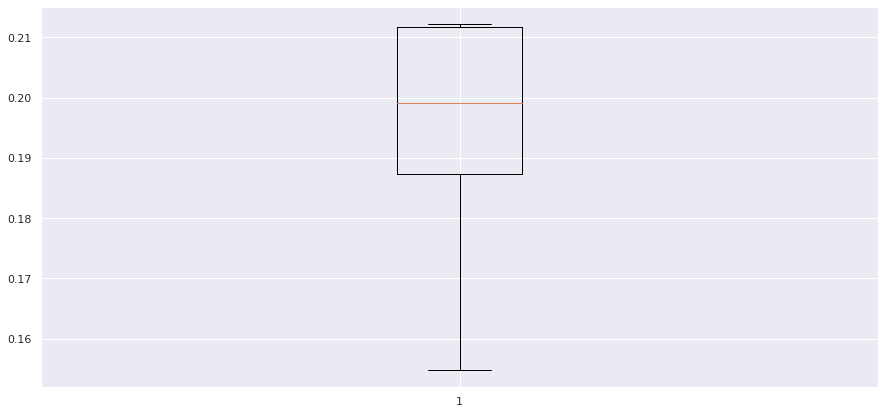

In [152]:
scoring = 'recall'
#Setting number of splits equal to 5
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)     
cv_result_bfr = cross_val_score(estimator=lr, X=X_train, y=y_train, scoring=scoring, cv=kfold)
#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr);

Metric  Train Accuracy  Test Accuracy  ...  Train F1-Score  Test F1-Score
Score            0.770          0.766  ...           0.304          0.280

[1 rows x 8 columns]

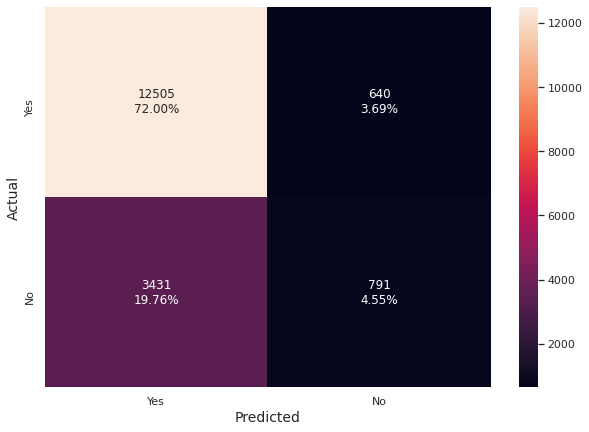

In [153]:
get_metrics_score(lr)
make_confusion_matrix(lr, y_test)

### Oversampling train data

In [154]:
from imblearn.over_sampling import SMOTE

print("Before UpSampling, counts of label 'Yes': {}".format(sum(y_train==1)))
print("Before UpSampling, counts of label 'No': {} \n".format(sum(y_train==0)))

sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1)   #Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

print("After UpSampling, counts of label 'Yes': {}".format(sum(y_train_over==1)))
print("After UpSampling, counts of label 'No': {} \n".format(sum(y_train_over==0)))

print('After UpSampling, the shape of train_X: {}'.format(X_train_over.shape))
print('After UpSampling, the shape of train_y: {} \n'.format(y_train_over.shape))

Before UpSampling, counts of label 'Yes': 9849
Before UpSampling, counts of label 'No': 30671 

After UpSampling, counts of label 'Yes': 30671
After UpSampling, counts of label 'No': 30671 

After UpSampling, the shape of train_X: (61342, 33)
After UpSampling, the shape of train_y: (61342,) 



In [155]:
log_reg_over = LogisticRegression(random_state=1)

# Training the basic logistic regression model with the training set 
log_reg_over.fit(X_train_over, y_train_over)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

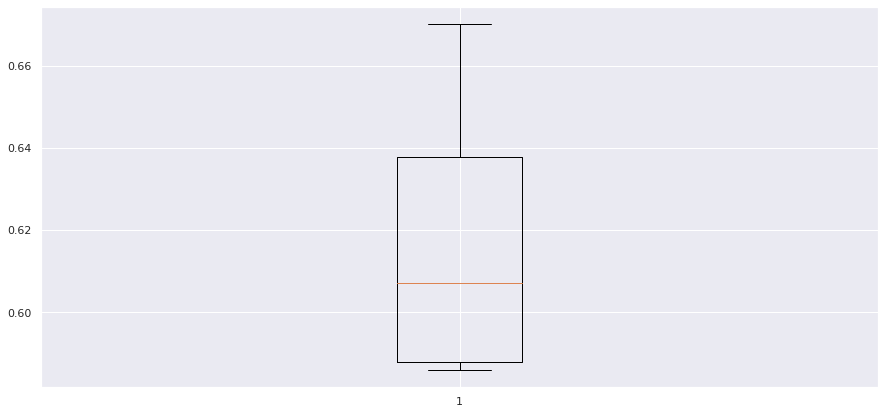

In [156]:
scoring = 'recall'
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)     #Setting number of splits equal to 5
cv_result_over = cross_val_score(estimator=log_reg_over, X=X_train_over, y=y_train_over, scoring=scoring, cv=kfold)
#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_over);

Metric  Train Accuracy  Test Accuracy  ...  Train F1-Score  Test F1-Score
Score            0.623          0.623  ...           0.440          0.436

[1 rows x 8 columns]

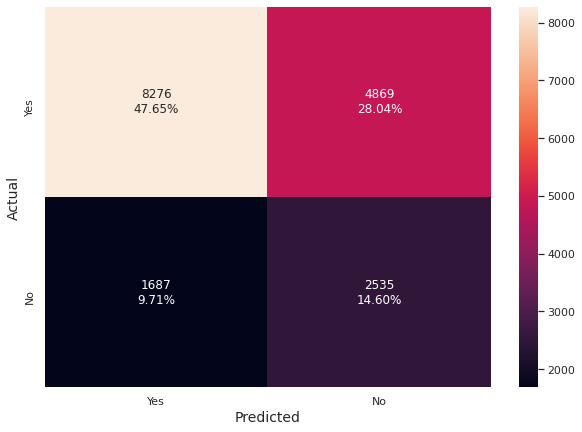

In [157]:
get_metrics_score(log_reg_over)
make_confusion_matrix(log_reg_over, y_test)

### Regularization

In [158]:
# Choose the type of classifier. 
lr_estimator = LogisticRegression(random_state=1)

# Grid of parameters to choose from
parameters = {'C': np.arange(0.1, 1.1, 0.1)}

# Run the grid search
grid_obj = GridSearchCV(lr_estimator, parameters, scoring='recall', n_jobs=-1)
grid_obj = grid_obj.fit(X_train_over, y_train_over)

# Set the clf to the best combination of parameters
lr_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
lr_estimator.fit(X_train_over, y_train_over)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Metric  Train Accuracy  Test Accuracy  ...  Train F1-Score  Test F1-Score
Score            0.629          0.625  ...           0.437          0.429

[1 rows x 8 columns]

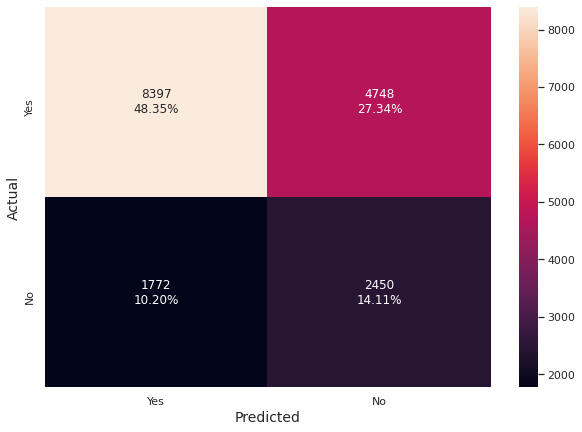

In [159]:
get_metrics_score(lr_estimator)
make_confusion_matrix(lr_estimator, y_test)

In [160]:
models = []  # Empty list to store all the models

# Appending pipelines for each model into the list

models.append(
    (
        "DTREE",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("decision_tree", DecisionTreeClassifier(random_state=1)),
            ]
        ),
    )
)


models.append(
    (
        "BAGGING",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("random_forest", BaggingClassifier(random_state=1)),
            ]
        ),
    )
)


models.append(
    (
        "RF",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("random_forest", RandomForestClassifier(random_state=1)),
            ]
        ),
    )
)

models.append(
    (
        "ADB",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("adaboost", AdaBoostClassifier(random_state=1)),
            ]
        ),
    )
)


models.append(
    (
        "GBM",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("gradient_boosting", GradientBoostingClassifier(random_state=1)),
            ]
        ),
    )
)


models.append(
    (
        "XGB",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("xgboost", XGBClassifier(random_state=1, eval_metric='logloss')),
            ]
        ),
    )
)

results = []  # Empty list to store all model's CV scores
names = []   # Empty list to store name of the models

# loop through all models to get the mean cross validated score
for name, model in models:
    scoring = "recall"
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    cv_result = cross_val_score(estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold)
    results.append(cv_result)
    names.append(name)

    print(f"{name}: {cv_result.mean() * 100}")

DTREE: 57.213669749131846
BAGGING: 44.908018448386535
RF: 31.0387658452202
ADB: 29.84057974750769
GBM: 32.09463950109953
XGB: 30.906713964933623


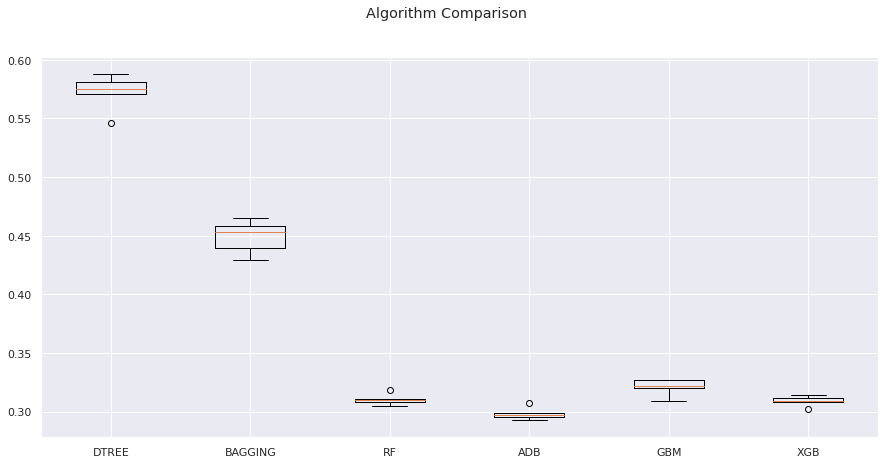

In [161]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(15, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names);

<a id=xgbc></a>
## <span style="color:blue">XGBoost Classifier</span>
<div style="text-align:right"><a href=#top>top</a></div>

### Hyperparameter Tuning using RandomizedSearchCV

In [162]:
%%time 

#Creating pipeline
pipe=make_pipeline(StandardScaler(),XGBClassifier(random_state=1,eval_metric='logloss', n_estimators=50))

#Parameter grid to pass in RandomizedSearchCV
param_grid={'xgbclassifier__n_estimators':np.arange(50,300,50),
            'xgbclassifier__scale_pos_weight':[0,1,2,5,10],
            'xgbclassifier__learning_rate':[0.01,0.1,0.2,0.05],
            'xgbclassifier__gamma':[0,1,3,5],
            'xgbclassifier__subsample':[0.7,0.8,0.9,1],
            'xgbclassifier__max_depth':np.arange(1,10,1),
            'xgbclassifier__reg_lambda':[0,1,2,5,10]}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, 
                                   scoring=scorer, cv=5, random_state=1, n_jobs=-1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print(f"Best Parameters:{randomized_cv.best_params_} \nScore: {randomized_cv.best_score_}")

Best Parameters:{'xgbclassifier__subsample': 1, 'xgbclassifier__scale_pos_weight': 2, 'xgbclassifier__reg_lambda': 2, 'xgbclassifier__n_estimators': 150, 'xgbclassifier__max_depth': 7, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__gamma': 0} 
Score: 0.7102867454226693
CPU times: user 25.4 s, sys: 498 ms, total: 25.9 s
Wall time: 27min 14s


In [215]:
X_train.shape

(40520, 33)

In [216]:
y_train.shape

(40520,)

Metric  Train Accuracy  Test Accuracy  ...  Train F1-Score  Test F1-Score
Score            0.914          0.875  ...           0.815          0.720

[1 rows x 8 columns]

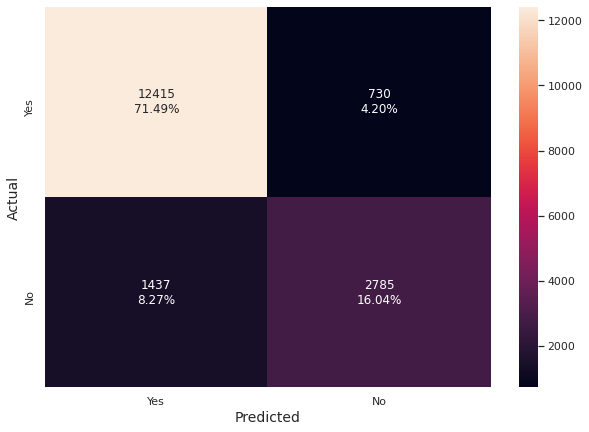

In [163]:
# Creating new pipeline with best parameters
xgb_tuned = make_pipeline(
    StandardScaler(),
    XGBClassifier(
        random_state=1,
        n_estimators=150,
        scale_pos_weight=2,
        reg_lambda=2,
        max_depth=7,
        subsample=1,
        learning_rate=0.1,
        gamma=0,
        eval_metric='logloss',
        n_jobs=-1
    )
)

# Fit the model on training data
xgb_tuned.fit(X_train, y_train)

#Calculating different metrics
get_metrics_score(xgb_tuned)

#Creating confusion matrix
make_confusion_matrix(xgb_tuned, y_test)

<a id=bagging></a>
## <span style="color:blue">Bagging Classifier</span>
<div style="text-align:right"><a href=#top>top</a></div>

### Hyperparameter tuning using GridSearchCV

In [164]:
%%time 

# Creating pipeline
pipe = make_pipeline(StandardScaler(), BaggingClassifier(random_state=1))

# Parameter grid to pass in GridSearchCV
param_grid = {
    'baggingclassifier__max_samples':  [0.7, 0.8, 0.9, 1], 
    'baggingclassifier__max_features': [0.7, 0.8, 0.9, 1],
    'baggingclassifier__n_estimators': [30, 40, 50, 70]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

print(f"Best Parameters:{grid_cv.best_params_} \nScore: {grid_cv.best_score_}")

Best Parameters:{'baggingclassifier__max_features': 0.9, 'baggingclassifier__max_samples': 0.8, 'baggingclassifier__n_estimators': 70} 
Score: 0.5664977581096411
CPU times: user 37 s, sys: 1.29 s, total: 38.3 s
Wall time: 28min 31s


Metric  Train Accuracy  Test Accuracy  ...  Train F1-Score  Test F1-Score
Score            0.999          0.846  ...           0.998          0.583

[1 rows x 8 columns]

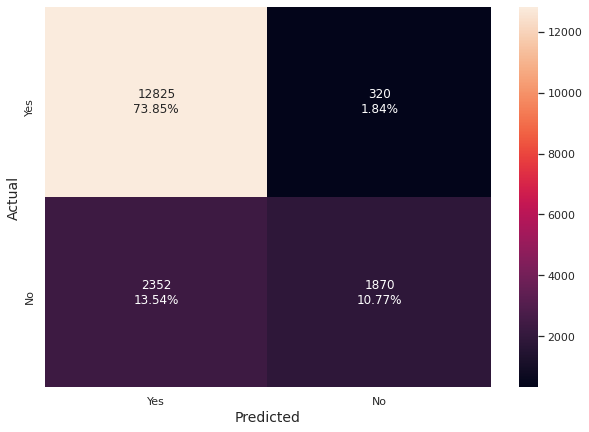

In [165]:
# Creating new pipeline with best parameters
bagg_tuned = make_pipeline(
    StandardScaler(),
    BaggingClassifier(
        max_features=0.9,
        max_samples=0.9,
        random_state=1,
        n_estimators=50,
        n_jobs=-1
    )
)

# Fit the model on training data
bagg_tuned.fit(X_train, y_train)

#Calculating different metrics
get_metrics_score(bagg_tuned)

#Creating confusion matrix
make_confusion_matrix(bagg_tuned, y_test)

<a id=dtree></a>
## <span style="color:blue">Decision Tree Classifier</span>
<div style="text-align:right"><a href=#top>top</a></div>

### Hyperparameter Tuning using GridSearchCV

In [166]:
%%time 

# Creating pipeline
pipe = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=1))

# Parameter grid to pass in GridSearchCV
param_grid = {
    'decisiontreeclassifier__max_depth': np.arange(2, 30), 
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 5, 7, 10],
    'decisiontreeclassifier__max_leaf_nodes' : [2, 3, 5, 10, 15],
    'decisiontreeclassifier__min_impurity_decrease': [0.0001,0.001,0.01,0.1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

print(f"Best parameters are {grid_cv.best_params_} \nScore={grid_cv.best_score_}:")

Best parameters are {'decisiontreeclassifier__max_depth': 8, 'decisiontreeclassifier__max_leaf_nodes': 15, 'decisiontreeclassifier__min_impurity_decrease': 0.0001, 'decisiontreeclassifier__min_samples_leaf': 1} 
Score=0.44728956272125975:
CPU times: user 1min 32s, sys: 7.7 s, total: 1min 40s
Wall time: 23min 3s


Metric  Train Accuracy  Test Accuracy  ...  Train F1-Score  Test F1-Score
Score            0.820          0.817  ...           0.462          0.445

[1 rows x 8 columns]

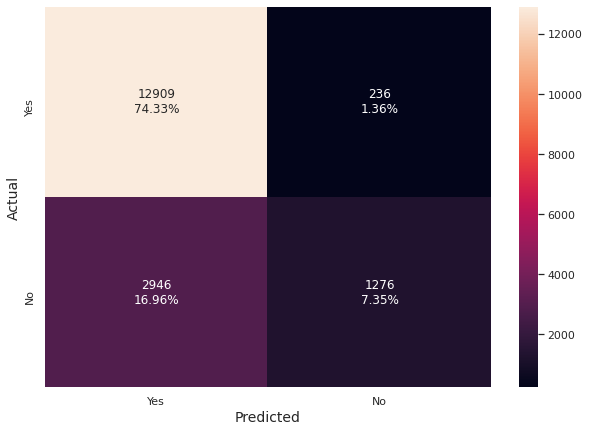

In [167]:
# Creating new pipeline with best parameters
dtree_tuned = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier(
        max_depth=7,
        max_leaf_nodes=15,
        random_state=1,
        min_impurity_decrease=0.0001,
        min_samples_leaf=1,
    )
)

# Fit the model on training data
dtree_tuned.fit(X_train, y_train)

#Calculating different metrics
get_metrics_score(dtree_tuned)

#Creating confusion matrix
make_confusion_matrix(dtree_tuned, y_test)

<a id=stacking></a>
## <span style="color:blue">Stacking Classifier</span>
<div style="text-align:right"><a href=#top>top</a></div>

Metric  Train Accuracy  Test Accuracy  ...  Train F1-Score  Test F1-Score
Score            0.994          0.851  ...           0.988          0.687

[1 rows x 8 columns]

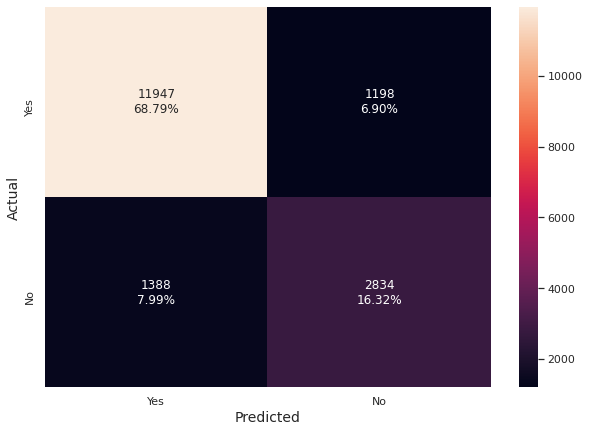

In [168]:
estimators = [('Bagging Classifier', bagg_tuned), ('Decision Tree', dtree_tuned)]
stacking_classifier= StackingClassifier(estimators=estimators, final_estimator=xgb_tuned)
stacking_classifier.fit(X_train, y_train)

#Calculating different metrics
get_metrics_score(stacking_classifier)

#Creating confusion matrix
make_confusion_matrix(stacking_classifier, y_test)

- I will use xgb_tuned model to predict the test set output variables

<a id=testset></a>
## <span style="color:blue">Test Set Prediction</span>
<div style="text-align:right"><a href=#top>top</a></div>

In [249]:
test = pd.read_csv('Test_set.csv')
test.columns

Index(['ID', 'loan_amnt', 'loan_term', 'interest_rate', 'loan_grade',
       'loan_subgrade', 'job_experience', 'home_ownership', 'annual_income',
       'income_verification_status', 'loan_purpose', 'state_code',
       'debt_to_income', 'delinq_2yrs', 'public_records', 'revolving_balance',
       'total_acc', 'interest_receive', 'application_type', 'last_week_pay',
       'total_current_balance', 'total_revolving_limit'],
      dtype='object')

In [250]:
test_id = test.ID
test_id.head()

0     4855329
1    66862420
2     3637416
3    53682249
4    53937165
Name: ID, dtype: int64

In [251]:
test.annual_income.fillna(test.annual_income.mean(), inplace=True)
test.last_week_pay.fillna(test.last_week_pay.mean(), inplace=True)
test.total_current_balance.fillna(test.total_current_balance.mean(), inplace=True)
test.total_revolving_limit.fillna(test.total_revolving_limit.mean(), inplace=True)
test.total_acc.fillna(test.total_acc.mean(), inplace=True)
test.delinq_2yrs.fillna(test.delinq_2yrs.mean(), inplace=True)
test.public_records.fillna(test.public_records.mean(), inplace=True)

In [252]:
job_experience = {'<5 Years':0, '6-10 years':1, '10+ years':2}
test['job_experience'] = test['job_experience'].map(job_experience).astype('Int32')

loan_term = {'3 years': 0, '5 years': 1}
test['loan_term'] = test['loan_term'].map(loan_term).astype('Int32')

loan_grade = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6}
test['loan_grade'] = test['loan_grade'].map(loan_grade).astype('Int32')

loan_subgrade = {'A1':0,  'A2':1,  'A3':2,  'A4':3,  'A5':4, 
                 'B1':5,  'B2':6,  'B3':7,  'B4':8,  'B5':9, 
                 'C1':10, 'C2':11, 'C3':12, 'C4':13, 'C5':14,
                 'D1':15, 'D2':16, 'D3':17, 'D4':18, 'D5':19,
                 'E1':20, 'E2':21, 'E3':22, 'E4':23, 'E5':24,
                 'F1':25, 'F2':26, 'F3':27, 'F4':28, 'F5':29,
                 'G1':30, 'G2':31, 'G3':32, 'G4':33, 'G5':34}
test['loan_subgrade'] = test['loan_subgrade'].map(loan_subgrade).astype('Int32')

home_ownership = {'MORTGAGE':0, 'RENT':1, 'OWN':2, 'OTHER':3, 'NONE':4}
test['home_ownership'] = test['home_ownership'].map(home_ownership).astype('Int32')

income_verification_status = {'Verified':0, 'Not Verified':1, 'Source Verified':2}
test['income_verification_status'] = test['income_verification_status'].map(income_verification_status).astype('Int32')

loan_purpose = {'debt_consolidation': 0, 'credit_card':1, 'home_improvement': 2, 'other': 3}
test['loan_purpose'] = test['loan_purpose'].map(loan_purpose).astype('Int32')

application_type = {'INDIVIDUAL': 0, 'JOINT':1}
test['application_type'] = test['application_type'].map(application_type).astype('Int32')

state_code = {'AK':0,  'AL':1,  'AR':2,  'AZ':3,  'CA':4 , 'CO':5,  'CT':6,  'DC':7,  'DE':8, 
              'FL':9,  'GA':10, 'HI':11, 'IA':12, 'ID':13, 'IL':14, 'IN':15, 'KS':16, 'KY':17, 
              'LA':18, 'MA':19, 'MD':20, 'ME':21, 'MI':22, 'MN':23, 'MO':24, 'MS':25, 'MT':26, 
              'NC':27, 'ND':28, 'NE':29, 'NH':30, 'NJ':31, 'NM':32, 'NV':33, 'NY':34, 'OH':35, 
              'OK':36, 'OR':37, 'PA':38, 'RI':39, 'SC':40, 'SD':41, 'TN':42, 'TX':43, 'UT':44, 
              'VA':45, 'VT':46, 'WA':47, 'WI':48, 'WV':49, 'WY':50}
test['state_code'] = test['state_code'].map(state_code).astype('Int32')

In [253]:
test.head()

ID  loan_amnt  ...  total_current_balance  total_revolving_limit
0   4855329      12000  ...             128098.000              25800.000
1  66862420      12000  ...             269396.000              23600.000
2   3637416      15000  ...             220135.000              34100.000
3  53682249      12000  ...              39436.000              21700.000
4  53937165      20150  ...              52764.000              12000.000

[5 rows x 22 columns]

In [254]:
test.isnull().sum()

ID                               0
loan_amnt                        0
loan_term                        0
interest_rate                    0
loan_grade                       0
loan_subgrade                    0
job_experience                2089
home_ownership                   0
annual_income                    0
income_verification_status       0
loan_purpose                     0
state_code                       0
debt_to_income                   0
delinq_2yrs                      0
public_records                   0
revolving_balance                0
total_acc                        0
interest_receive                 0
application_type                 0
last_week_pay                    0
total_current_balance            0
total_revolving_limit            0
dtype: int64

In [255]:
test.shape

(39933, 22)

In [256]:
test_copy = test.copy()

In [257]:
imputer = KNNImputer(n_neighbors=5)

In [258]:
try:
    test.drop(['ID'], axis=1, inplace=True)
except:
    print('Already dropped')

In [259]:
print(test.columns)
test.shape

Index(['loan_amnt', 'loan_term', 'interest_rate', 'loan_grade',
       'loan_subgrade', 'job_experience', 'home_ownership', 'annual_income',
       'income_verification_status', 'loan_purpose', 'state_code',
       'debt_to_income', 'delinq_2yrs', 'public_records', 'revolving_balance',
       'total_acc', 'interest_receive', 'application_type', 'last_week_pay',
       'total_current_balance', 'total_revolving_limit'],
      dtype='object')


(39933, 21)

In [260]:
test.dtypes

loan_amnt                       int64
loan_term                       Int32
interest_rate                 float64
loan_grade                      Int32
loan_subgrade                   Int32
job_experience                  Int32
home_ownership                  Int32
annual_income                 float64
income_verification_status      Int32
loan_purpose                    Int32
state_code                      Int32
debt_to_income                float64
delinq_2yrs                   float64
public_records                float64
revolving_balance               int64
total_acc                     float64
interest_receive              float64
application_type                Int32
last_week_pay                 float64
total_current_balance         float64
total_revolving_limit         float64
dtype: object

In [263]:
# test = pd.DataFrame(imputer.fit_transform(test), columns=test.columns)
test["job_experience"] = test.job_experience.fillna(test.job_experience.value_counts().index[0])
print(f"Imputation done. Missing values: {test.job_experience.isnull().sum()}")
# test.fillna(test.mean(),inplace = True)

Imputation done. Missing values: 0


In [265]:
test = pd.DataFrame(imputer.fit_transform(test), columns=test.columns)

In [264]:
#Checking that no column has missing values in train or test sets
print(test.isna().sum())

loan_amnt                     0
loan_term                     0
interest_rate                 0
loan_grade                    0
loan_subgrade                 0
job_experience                0
home_ownership                0
annual_income                 0
income_verification_status    0
loan_purpose                  0
state_code                    0
debt_to_income                0
delinq_2yrs                   0
public_records                0
revolving_balance             0
total_acc                     0
interest_receive              0
application_type              0
last_week_pay                 0
total_current_balance         0
total_revolving_limit         0
dtype: int64


In [266]:
test.shape

(39933, 21)

In [191]:
## Function to inverse the encoding
def test_inverse_mapping(x, y):
    inv_dict = {v: k for k, v in x.items()}
    test[y] = np.round(test[y]).map(inv_dict).astype('category')

In [267]:
test_inverse_mapping(job_experience,'job_experience')
test_inverse_mapping(loan_term,'loan_term')
test_inverse_mapping(loan_grade,'loan_grade')
#inverse_mapping(loan_subgrade,'loan_subgrade')
test_inverse_mapping(home_ownership,'home_ownership')
test_inverse_mapping(income_verification_status,'income_verification_status')
test_inverse_mapping(loan_purpose,'loan_purpose')
test_inverse_mapping(application_type,'application_type')
#inverse_mapping(state_code,'state_code')

In [193]:
test.head()

ID  loan_amnt  ...  total_current_balance  total_revolving_limit
0   4855329      12000  ...             128098.000              25800.000
1  66862420      12000  ...             269396.000              23600.000
2   3637416      15000  ...             220135.000              34100.000
3  53682249      12000  ...              39436.000              21700.000
4  53937165      20150  ...              52764.000              12000.000

[5 rows x 22 columns]

In [268]:
cols = test.select_dtypes(include=['object','category'])
for i in cols.columns:
    print(test[i].value_counts(dropna=False))
    print('*'*30)

3 years    28110
5 years    11823
Name: loan_term, dtype: int64
******************************
B    11551
C    10948
A     6764
D     6237
E     3158
F     1030
G      245
Name: loan_grade, dtype: int64
******************************
<5 Years      19379
10+ years     13146
6-10 years     7408
Name: job_experience, dtype: int64
******************************
MORTGAGE    20008
RENT        15938
OWN          3979
OTHER           6
NONE            2
Name: home_ownership, dtype: int64
******************************
Source Verified    14780
Verified           13195
Not Verified       11958
Name: income_verification_status, dtype: int64
******************************
debt_consolidation    23473
credit_card            9383
other                  4693
home_improvement       2384
Name: loan_purpose, dtype: int64
******************************
INDIVIDUAL    39909
JOINT            24
Name: application_type, dtype: int64
******************************


In [269]:
test = pd.get_dummies(test, drop_first=True)
test.shape

(39933, 33)

In [271]:
test.columns

Index(['loan_amnt', 'interest_rate', 'loan_subgrade', 'annual_income',
       'state_code', 'debt_to_income', 'delinq_2yrs', 'public_records',
       'revolving_balance', 'total_acc', 'interest_receive', 'last_week_pay',
       'total_current_balance', 'total_revolving_limit', 'loan_term_5 years',
       'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E',
       'loan_grade_F', 'loan_grade_G', 'job_experience_6-10 years',
       'job_experience_<5 Years', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'income_verification_status_Source Verified',
       'income_verification_status_Verified',
       'loan_purpose_debt_consolidation', 'loan_purpose_home_improvement',
       'loan_purpose_other', 'application_type_JOINT'],
      dtype='object')

In [270]:
test.shape

(39933, 33)

In [272]:
pred = xgb_tuned.predict(test)
print(f"Prediction has length: {len(pred)}")

Prediction has length: 39933


In [273]:
prediction_dict = {
    'ID': test_id,
    'default': pred
}
submit_df = pd.DataFrame(prediction_dict)
submit_df.head()

ID  default
0   4855329    1.000
1  66862420    0.000
2   3637416    1.000
3  53682249    0.000
4  53937165    0.000

In [274]:
submit_df.to_csv('/home/sub4.csv', index=False)